# SAOCOM InSAR Analysis - Refactored (v2)

**Improved workflow: Outlier detection now happens BEFORE mask creation**

### Key Workflow Improvements:
1. Load SAOCOM data and filter by coherence
2. Apply KNN neighbor filtering
3. Sample DEMs at SAOCOM locations
4. **Calculate residuals and detect outliers** ⬅️ NEW POSITION
5. **Create hull mask from cleaned data** ⬅️ NOW ACCURATE
6. Proceed with analysis using cleaned dataset

This ensures the hull mask and void analysis reflect only valid points.


In [1]:
# Cell 1: Environment Info
# =============================================================================
import sys
import os

print(f"Python executable: {sys.executable}")
print(f"Python version: {sys.version}")
print(f"Environment location: {os.path.dirname(sys.executable)}")



Python executable: C:\Users\colto\Documents\GitHub\saocom_project\.venv\Scripts\python.exe
Python version: 3.13.5 (tags/v3.13.5:6cb20a2, Jun 11 2025, 16:15:46) [MSC v.1943 64 bit (AMD64)]
Environment location: C:\Users\colto\Documents\GitHub\saocom_project\.venv\Scripts


In [2]:
# Cell 2: Imports and Configuration
# =============================================================================
from pathlib import Path
from typing import Dict, Tuple, Optional
import warnings

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn as sns

import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.transform import from_bounds, rowcol
from rasterio.mask import mask
from rasterio import features
from rasterio.features import shapes
from rasterio.plot import show

from shapely.geometry import Point, box, shape
from dbfread import DBF
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from scipy import ndimage, stats
from scipy.interpolate import griddata

warnings.filterwarnings('ignore')

# Directory setup
DATA_DIR = Path("data")
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)
print(f"Data directory: {DATA_DIR}")

# Constants
COHERENCE_THRESHOLD = 0.3
NODATA = -9999
GRID_SIZE = 10
TARGET_CRS = 'EPSG:32632'

# CORINE Land Cover Classes
CORINE_CLASSES = {
    111: 'Continuous urban fabric', 112: 'Discontinuous urban fabric',
    121: 'Industrial or commercial units', 122: 'Road and rail networks',
    123: 'Port areas', 124: 'Airports', 131: 'Mineral extraction sites',
    132: 'Dump sites', 133: 'Construction sites', 141: 'Green urban areas',
    142: 'Sport and leisure facilities', 211: 'Non-irrigated arable land',
    212: 'Permanently irrigated land', 213: 'Rice fields', 221: 'Vineyards',
    222: 'Fruit trees and berry plantations', 223: 'Olive groves',
    231: 'Pastures', 241: 'Annual crops with permanent crops',
    242: 'Complex cultivation patterns', 243: 'Agriculture/natural mix',
    244: 'Agro-forestry areas', 311: 'Broad-leaved forest',
    312: 'Coniferous forest', 313: 'Mixed forest', 321: 'Natural grasslands',
    322: 'Moors and heathland', 323: 'Sclerophyllous vegetation',
    324: 'Transitional woodland-shrub', 331: 'Beaches, dunes, sands',
    332: 'Bare rocks', 333: 'Sparsely vegetated areas', 334: 'Burnt areas',
    335: 'Glaciers and perpetual snow', 411: 'Inland marshes',
    412: 'Peat bogs', 421: 'Salt marshes', 422: 'Salines',
    423: 'Intertidal flats', 511: 'Water courses', 512: 'Water bodies',
    521: 'Coastal lagoons', 522: 'Estuaries', 523: 'Sea and ocean'
}

# CORINE Colors (RGB 0-255)
CORINE_COLORS = {
    111: (102, 0, 102), 112: (153, 51, 153), 121: (204, 102, 204), 122: (80, 80, 80),
    123: (120, 120, 120), 124: (160, 160, 160), 131: (255, 0, 255), 132: (178, 34, 34),
    133: (255, 150, 180), 141: (120, 200, 120), 142: (100, 180, 100),
    211: (230, 230, 50), 212: (235, 200, 0), 213: (220, 180, 0), 221: (255, 140, 0),
    222: (255, 165, 79), 223: (204, 153, 0), 231: (210, 210, 80), 241: (200, 170, 100),
    242: (210, 160, 70), 243: (190, 150, 80), 244: (179, 143, 0),
    311: (0, 153, 102), 312: (0, 102, 76), 313: (0, 128, 128), 321: (150, 220, 150),
    322: (102, 204, 153), 323: (130, 180, 130), 324: (51, 153, 102), 331: (210, 180, 140),
    332: (140, 140, 140), 333: (170, 170, 120), 334: (40, 40, 40), 335: (180, 210, 230),
    411: (120, 170, 230), 412: (80, 140, 220), 421: (150, 190, 240), 422: (140, 170, 210),
    423: (100, 160, 210), 511: (0, 102, 204), 512: (0, 76, 153), 521: (51, 102, 153),
    522: (0, 51, 102), 523: (0, 25, 76)
}
CORINE_COLORS_MPL = {k: tuple(c/255 for c in rgb) for k, rgb in CORINE_COLORS.items()}

# File discovery
def discover_files() -> Dict[str, Optional[Path]]:
    """Discover all required data files."""
    patterns = {
        'saocom': ("saocom_csv", "*.csv"),
        'tinitaly': ("tinitaly", "*.tif"),
        'copernicus': ("copernicus", "*.tif"),
        'corine': ("ground_cover", "*.tif"),
        'sentinel': ("sentinel_data", "*.tif")
    }
    
    paths = {}
    for key, (subdir, pattern) in patterns.items():
        files = list((DATA_DIR / subdir).glob(pattern))
        paths[key] = files[0] if files else None
    
    # Find CORINE DBF
    if paths['corine']:
        dbf_candidates = list((DATA_DIR / "ground_cover").glob(f"{paths['corine'].name}.vat.dbf"))
        paths['corine_dbf'] = dbf_candidates[0] if dbf_candidates else None
    
    return paths

file_paths = discover_files()
saocom_path = file_paths['saocom']
tinitaly_path = file_paths['tinitaly']
copernicus_path = file_paths['copernicus']
corine_path = file_paths['corine']
corine_dbf_path = file_paths.get('corine_dbf')
sentinel_path = file_paths['sentinel']



Data directory: data


In [3]:
# Cell 3: Load and Prepare SAOCOM Data
# =============================================================================
def load_saocom_data(path: Path, coherence_threshold: float = COHERENCE_THRESHOLD) -> gpd.GeoDataFrame:
    """Load and filter SAOCOM CSV data, convert to GeoDataFrame."""
    df = pd.read_csv(path)
    df.columns = ['ID', 'SVET', 'LVET', 'LAT', 'LAT2', 'LON', 'LON2', 
                  'HEIGHT', 'HEIGHT_WRT_DEM', 'SIGMA_HEIGHT', 'COHER']
    
    # Convert to numeric
    numeric_cols = ['LAT', 'LON', 'LAT2', 'LON2', 'HEIGHT', 'COHER']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    
    # Filter valid data
    df = (df.dropna(subset=numeric_cols)
            .query('LAT2 != 0 and LON2 != 0')
            .rename(columns={'LAT': 'LAT_old', 'LON': 'LON_old', 
                           'LAT2': 'LAT', 'LON2': 'LON'}))
    
    # Apply coherence threshold
    df_filtered = df[df['COHER'] >= coherence_threshold]
    
    # Create GeoDataFrame and reproject
    geometry = [Point(lon, lat) for lon, lat in zip(df_filtered['LON'], df_filtered['LAT'])]
    gdf = gpd.GeoDataFrame(df_filtered, geometry=geometry, crs='EPSG:4326').to_crs(TARGET_CRS)
    gdf['x_utm'] = gdf.geometry.x
    gdf['y_utm'] = gdf.geometry.y
    
    return gdf

def read_raster_meta(path: Path) -> Tuple:
    """Read raster metadata (CRS, resolution, bounds, nodata)."""
    with rasterio.open(path) as src:
        return src.crs, src.res, src.bounds, src.nodata

saocom_gdf = load_saocom_data(saocom_path)
tinitaly_crs, tinitaly_res, tinitaly_bounds, tinitaly_nodata = read_raster_meta(tinitaly_path)
copernicus_crs, copernicus_res, copernicus_bounds, copernicus_nodata = read_raster_meta(copernicus_path)



In [4]:
# Cell 4: Spatial Processing Setup (Initial)
# =============================================================================
def remove_isolated_knn(gdf: gpd.GeoDataFrame, k: int = 100, 
                        distance_threshold: float = 1000) -> gpd.GeoDataFrame:
    """Remove isolated points using KNN distance thresholding."""
    coords = np.column_stack((gdf.geometry.x, gdf.geometry.y))
    distances = NearestNeighbors(n_neighbors=k+1).fit(coords).kneighbors(coords)[0]
    print(f"Processing {len(distances)} points")
    return gdf[distances[:, 1:].mean(axis=1) < distance_threshold].reset_index(drop=True)

def score_outliers_isolation_forest(gdf: gpd.GeoDataFrame, residual_col: str, 
                                    **kwargs) -> gpd.GeoDataFrame:
    """Add outlier scores using Isolation Forest on (x, y, residual)."""
    if gdf.empty or residual_col not in gdf.columns:
        gdf = gdf.copy()
        gdf['outlier_score'] = np.nan
        return gdf
    
    pts = np.column_stack((gdf.geometry.x, gdf.geometry.y, gdf[residual_col]))
    valid = np.isfinite(pts).all(axis=1)
    
    result_gdf = gdf.copy()
    result_gdf['outlier_score'] = np.nan
    
    if valid.sum() < 10:
        return result_gdf
    
    scaler = StandardScaler()
    pts_scaled = scaler.fit_transform(pts[valid])
    
    clf = IsolationForest(random_state=42, **kwargs)
    scores = clf.fit_predict(pts_scaled)
    result_gdf.loc[valid, 'outlier_score'] = scores
    
    return result_gdf

def detect_outliers_residual(gdf: gpd.GeoDataFrame, residual_col: str, 
                            method: str = 'iqr', threshold: float = 3.0) -> gpd.GeoDataFrame:
    """Detect outliers using IQR or z-score method."""
    result_gdf = gdf.copy()
    result_gdf['is_outlier'] = False
    
    if residual_col not in gdf.columns or gdf[residual_col].isna().all():
        return result_gdf
    
    vals = gdf[residual_col].dropna()
    
    if method == 'iqr':
        q1, q3 = vals.quantile(0.25), vals.quantile(0.75)
        iqr = q3 - q1
        lower, upper = q1 - threshold * iqr, q3 + threshold * iqr
        result_gdf['is_outlier'] = (gdf[residual_col] < lower) | (gdf[residual_col] > upper)
    elif method == 'zscore':
        z = np.abs((gdf[residual_col] - vals.mean()) / vals.std())
        result_gdf['is_outlier'] = z > threshold
    
    return result_gdf

# Datum verification
tinitaly_needs_reproject = str(tinitaly_crs) != TARGET_CRS
copernicus_needs_reproject = str(copernicus_crs) != TARGET_CRS

tinitaly_wkt, copernicus_wkt = tinitaly_crs.to_wkt(), copernicus_crs.to_wkt()
tinitaly_vertical = 'EGM2008' in tinitaly_wkt or 'geoid' in tinitaly_wkt.lower()
copernicus_vertical = 'EGM2008' in copernicus_wkt or 'geoid' in copernicus_wkt.lower()

# Initial study area bounds (will be refined after outlier removal)
study_bounds = saocom_gdf.total_bounds

# Define target grid based on initial bounds
xmin, ymin, xmax, ymax = study_bounds
xmin_grid = np.floor(xmin / GRID_SIZE) * GRID_SIZE
ymin_grid = np.floor(ymin / GRID_SIZE) * GRID_SIZE
xmax_grid = np.ceil(xmax / GRID_SIZE) * GRID_SIZE
ymax_grid = np.ceil(ymax / GRID_SIZE) * GRID_SIZE

grid_width = int((xmax_grid - xmin_grid) / GRID_SIZE)
grid_height = int((ymax_grid - ymin_grid) / GRID_SIZE)
target_transform = from_bounds(xmin_grid, ymin_grid, xmax_grid, ymax_grid, 
                               grid_width, grid_height)

print(f"Initial Grid: {grid_width} x {grid_height} pixels ({GRID_SIZE}m resolution)")
print(f"Initial Bounds: [{xmin_grid:.1f}, {ymin_grid:.1f}, {xmax_grid:.1f}, {ymax_grid:.1f}]")



Initial Grid: 1052 x 804 pixels (10m resolution)
Initial Bounds: [664020.0, 5037500.0, 674540.0, 5045540.0]


In [5]:
# Cell 5: Resample DEMs to 10m Grid
# =============================================================================
# Raster profile
profile = {
    'driver': 'GTiff', 'dtype': 'float32', 'width': grid_width, 'height': grid_height,
    'count': 1, 'crs': TARGET_CRS, 'transform': target_transform,
    'nodata': NODATA, 'compress': 'lzw'
}

def resample_to_10m(src_path: Path, out_name: str) -> Tuple[np.ndarray, Path]:
    """Resample raster to 10m grid."""
    arr = np.full((grid_height, grid_width), NODATA, dtype=np.float32)
    with rasterio.open(src_path) as src:
        reproject(
            rasterio.band(src, 1), arr,
            src_transform=src.transform, src_crs=src.crs,
            dst_transform=target_transform, dst_crs=TARGET_CRS,
            resampling=Resampling.bilinear
        )
    out_path = RESULTS_DIR / out_name
    with rasterio.open(out_path, 'w', **profile) as dst:
        dst.write(arr, 1)
    return arr, out_path

# Resample DEMs
tinitaly_10m, tinitaly_10m_path = resample_to_10m(tinitaly_path, "tinitaly_10m.tif")
copernicus_10m, copernicus_10m_path = resample_to_10m(copernicus_path, "copernicus_10m.tif")



In [6]:
# Cell 6: Sample DEMs at SAOCOM Locations
# =============================================================================
def sample_raster_at_points(arr: np.ndarray, gdf: gpd.GeoDataFrame, 
                           transform) -> np.ndarray:
    """Sample raster values at point locations (vectorized)."""
    xs, ys = gdf.geometry.x.values, gdf.geometry.y.values
    rows, cols = rowcol(transform, xs, ys)
    inb = (rows >= 0) & (rows < grid_height) & (cols >= 0) & (cols < grid_width)
    
    out = np.full(len(gdf), np.nan, dtype=np.float32)
    v = arr[rows[inb], cols[inb]]
    out[inb] = np.where(v == NODATA, np.nan, v)
    return out

saocom_gdf['tinitaly_height'] = sample_raster_at_points(tinitaly_10m, saocom_gdf, target_transform)
saocom_gdf['copernicus_height'] = sample_raster_at_points(copernicus_10m, saocom_gdf, target_transform)

# Calculate absolute heights (calibrated to reference DEMs)
saocom_gdf['HEIGHT_ABSOLUTE_TIN'] = saocom_gdf['HEIGHT'] + saocom_gdf['tinitaly_height']
saocom_gdf['HEIGHT_ABSOLUTE_COP'] = saocom_gdf['HEIGHT'] + saocom_gdf['copernicus_height']

# Filter valid samples
valid_mask_tin = (saocom_gdf['tinitaly_height'].notna() & 
                  (saocom_gdf['tinitaly_height'] != NODATA))
valid_mask_cop = (saocom_gdf['copernicus_height'].notna() & 
                  (saocom_gdf['copernicus_height'] != NODATA))

print(f"SAOCOM points with valid TINITALY: {valid_mask_tin.sum():,}")
print(f"SAOCOM points with valid Copernicus: {valid_mask_cop.sum():,}")



SAOCOM points with valid TINITALY: 68,361
SAOCOM points with valid Copernicus: 68,512


In [7]:
# Cell 8: Outlier Detection (Before Creating Final Mask)
# =============================================================================
print("\n" + "="*70)
print("OUTLIER DETECTION - PERFORMED BEFORE MASK CREATION")
print("="*70)

# Calculate residuals
saocom_gdf['diff_tinitaly'] = saocom_gdf['HEIGHT_ABSOLUTE_TIN'] - saocom_gdf['tinitaly_height']
saocom_gdf['diff_copernicus'] = saocom_gdf['HEIGHT_ABSOLUTE_COP'] - saocom_gdf['copernicus_height']

print(f"\nTotal points before outlier detection: {len(saocom_gdf):,}")

# Apply outlier detection using residuals
saocom_gdf = score_outliers_isolation_forest(saocom_gdf, 'diff_tinitaly', 
                                             contamination=0.05, n_estimators=100)
saocom_gdf = detect_outliers_residual(saocom_gdf, 'diff_tinitaly', method='iqr', threshold=2.5)

# Separate outliers and cleaned data
saocom_outliers = saocom_gdf[saocom_gdf['is_outlier']].copy()
saocom_cleaned = saocom_gdf[~saocom_gdf['is_outlier']].copy()

print(f"Outliers detected: {len(saocom_outliers):,} ({len(saocom_outliers)/len(saocom_gdf)*100:.1f}%)")
print(f"Cleaned dataset: {len(saocom_cleaned):,} ({len(saocom_cleaned)/len(saocom_gdf)*100:.1f}%)")

# Update saocom_gdf to use only cleaned points for mask creation
print("\n⚠️  IMPORTANT: Using cleaned dataset (outliers removed) for hull mask creation")
saocom_gdf = saocom_cleaned.copy()
print(f"Active SAOCOM dataset now has: {len(saocom_gdf):,} points")
print("="*70 + "\n")




OUTLIER DETECTION - PERFORMED BEFORE MASK CREATION

Total points before outlier detection: 68,512
Outliers detected: 246 (0.4%)
Cleaned dataset: 68,266 (99.6%)

⚠️  IMPORTANT: Using cleaned dataset (outliers removed) for hull mask creation
Active SAOCOM dataset now has: 68,266 points



In [8]:
# Cell 9: Create Hull Mask from Cleaned Data
# =============================================================================
print("Creating hull mask from cleaned SAOCOM points...")

# Create hull from cleaned points
buffer_dist = 100
saocom_buffer = saocom_gdf.geometry.buffer(buffer_dist)
data_hull = saocom_buffer.unary_union.convex_hull
hull_gdf = gpd.GeoDataFrame([1], geometry=[data_hull], crs=TARGET_CRS)

# Rasterize hull mask
hull_mask = features.rasterize(
    [data_hull], out_shape=(grid_height, grid_width),
    transform=target_transform, fill=0, all_touched=True, dtype='uint8'
).astype(bool)

def mask_and_write(arr: np.ndarray, out_name: str) -> Tuple[np.ndarray, Path]:
    """Apply hull mask and write to disk."""
    masked = arr.copy()
    masked[~hull_mask] = NODATA
    out_path = RESULTS_DIR / out_name
    with rasterio.open(out_path, 'w', **profile) as dst:
        dst.write(masked, 1)
    return masked, out_path

# Apply mask to DEMs
tinitaly_10m, tinitaly_masked_path = mask_and_write(tinitaly_10m, "tinitaly_10m_masked.tif")
copernicus_10m, copernicus_masked_path = mask_and_write(copernicus_10m, "copernicus_10m_masked.tif")

print(f"✓ Hull mask created from {len(saocom_gdf):,} cleaned points")
print(f"✓ DEMs masked and saved")



Creating hull mask from cleaned SAOCOM points...
✓ Hull mask created from 68,266 cleaned points
✓ DEMs masked and saved


In [9]:
# Cell 10: Coverage and Void Analysis (Using Cleaned Data)
# =============================================================================
# SAOCOM coverage grid
saocom_rows, saocom_cols = rowcol(target_transform, 
                                  saocom_gdf.geometry.x.values,
                                  saocom_gdf.geometry.y.values)
inb = ((saocom_rows >= 0) & (saocom_rows < grid_height) & 
       (saocom_cols >= 0) & (saocom_cols < grid_width))
saocom_coverage = np.zeros((grid_height, grid_width), dtype=bool)
saocom_coverage[saocom_rows[inb], saocom_cols[inb]] = True

# Void statistics
study_area_mask = hull_mask
void_mask = study_area_mask & ~saocom_coverage

study_pixels = study_area_mask.sum()
void_pixels = void_mask.sum()
saocom_pixels = (study_area_mask & saocom_coverage).sum()

pixel_area_km2 = (GRID_SIZE ** 2) / 1_000_000
study_area_km2 = study_pixels * pixel_area_km2
void_area_km2 = void_pixels * pixel_area_km2
saocom_area_km2 = saocom_pixels * pixel_area_km2

print(f"\n{'='*60}")
print(f"COVERAGE STATISTICS (inside hull, 10m grid)")
print(f"{'='*60}")
print(f"Total study area: {study_area_km2:.2f} km² ({study_pixels:,} pixels)")
print(f"SAOCOM coverage:  {saocom_area_km2:.2f} km² ({saocom_pixels:,} pixels, "
      f"{saocom_pixels/study_pixels*100:.1f}%)")
print(f"Void areas:       {void_area_km2:.2f} km² ({void_pixels:,} pixels, "
      f"{void_pixels/study_pixels*100:.1f}%)")
print(f"{'='*60}\n")




COVERAGE STATISTICS (inside hull, 10m grid)
Total study area: 59.73 km² (597,312 pixels)
SAOCOM coverage:  6.57 km² (65,689 pixels, 11.0%)
Void areas:       53.16 km² (531,623 pixels, 89.0%)



In [10]:
# Cell 11: Reference DEM Comparison
# =============================================================================
def calculate_nmad(series: pd.Series) -> float:
    """Calculate Normalized Median Absolute Deviation."""
    return (series - series.median()).abs().median() * 1.4826

# Elevation difference
tinitaly_data = tinitaly_10m.copy()
copernicus_data = copernicus_10m.copy()
elevation_diff = tinitaly_data - copernicus_data
valid_mask = (tinitaly_data != NODATA) & (copernicus_data != NODATA)

valid_diffs = elevation_diff[valid_mask]
valid_tinitaly = tinitaly_data[valid_mask]
valid_copernicus = copernicus_data[valid_mask]

# Comparison statistics
ref_stats = {
    'n_pixels': int(valid_mask.sum()),
    'mean_diff': float(valid_diffs.mean()),
    'median_diff': float(np.median(valid_diffs)),
    'std_diff': float(valid_diffs.std()),
    'nmad': calculate_nmad(pd.Series(valid_diffs)),
    'mae': float(np.abs(valid_diffs).mean()),
    'rmse': float(np.sqrt((valid_diffs**2).mean())),
    'min_diff': float(valid_diffs.min()),
    'max_diff': float(valid_diffs.max()),
    'q05': float(np.percentile(valid_diffs, 5)),
    'q95': float(np.percentile(valid_diffs, 95))
}

print(f"\n{'='*60}")
print(f"REFERENCE DEM COMPARISON (TINITALY vs Copernicus)")
print(f"{'='*60}")
for key, val in ref_stats.items():
    if key == 'n_pixels':
        print(f"{key:<15}: {val:,}")
    else:
        print(f"{key:<15}: {val:+.3f} m")
print(f"{'='*60}\n")




REFERENCE DEM COMPARISON (TINITALY vs Copernicus)
n_pixels       : 536,709
mean_diff      : -1.978 m
median_diff    : -0.566 m
std_diff       : +4.292 m
nmad           : +2.210 m
mae            : +2.860 m
rmse           : +4.726 m
min_diff       : -43.862 m
max_diff       : +14.280 m
q05            : -11.151 m
q95            : +2.219 m



In [11]:
# Cell 10: Load and Process CORINE Land Cover
# =============================================================================
# Load DBF lookup
dbf_table = DBF(corine_dbf_path, load=True)
lookup_df = pd.DataFrame(iter(dbf_table))
value_to_code = dict(zip(lookup_df['Value'], lookup_df['CODE_18']))
value_to_label = dict(zip(lookup_df['Value'], lookup_df['LABEL3']))
code_to_label = dict(zip(lookup_df['CODE_18'], lookup_df['LABEL3']))

# Load and crop CORINE
with rasterio.open(corine_path) as src:
    hull_corine_crs = hull_gdf.to_crs(src.crs)
    corine_raw, crop_transform = mask(src, hull_corine_crs.geometry, crop=True)
    corine_raw = corine_raw[0]
    corine_crs = src.crs

# Resample CORINE to 10m grid
corine_10m = np.full((grid_height, grid_width), 0, dtype=np.uint16)
reproject(
    corine_raw, corine_10m,
    src_transform=crop_transform, src_crs=corine_crs,
    dst_transform=target_transform, dst_crs=TARGET_CRS,
    resampling=Resampling.nearest
)

# Remap values to CLC codes
corine_remapped = np.zeros_like(corine_10m)
for val, code in value_to_code.items():
    corine_remapped[corine_10m == val] = code

corine_10m = corine_remapped
corine_10m[~hull_mask] = 0

# Save to disk
corine_10m_path = RESULTS_DIR / "corine_10m_remapped.tif"
prof_corine = profile.copy()
prof_corine.update(dtype='uint16', nodata=0)
with rasterio.open(corine_10m_path, 'w', **prof_corine) as dst:
    dst.write(corine_10m, 1)

unique_lc = np.unique(corine_10m[corine_10m > 0])
print(f"\nUnique CORINE classes in study area: {len(unique_lc)}")




Unique CORINE classes in study area: 10


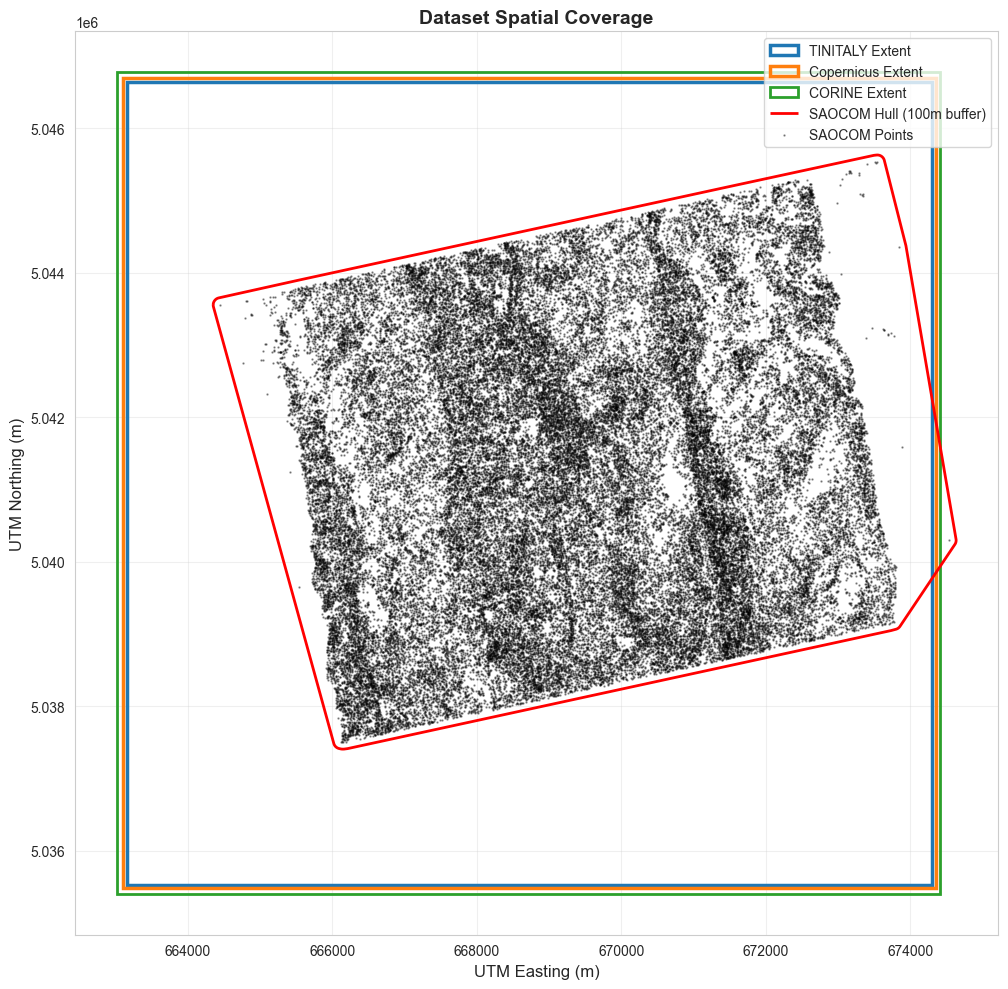

In [12]:
# Cell 11: Spatial Overlap Visualization
# =============================================================================
fig, ax = plt.subplots(figsize=(12, 10), facecolor='white')
ax.set_facecolor('white')

# TINITALY extent
with rasterio.open(tinitaly_path) as src:
    dem_bounds_target = rasterio.warp.transform_bounds(src.crs, TARGET_CRS, *src.bounds)
    ax.add_patch(mpatches.Rectangle(
        (dem_bounds_target[0], dem_bounds_target[1]),
        dem_bounds_target[2] - dem_bounds_target[0],
        dem_bounds_target[3] - dem_bounds_target[1],
        fill=False, edgecolor='#1f77b4', linewidth=2.5, label='TINITALY Extent'))

# Copernicus extent
with rasterio.open(copernicus_path) as src:
    cop_bounds_target = rasterio.warp.transform_bounds(src.crs, TARGET_CRS, *src.bounds)
    ax.add_patch(mpatches.Rectangle(
        (cop_bounds_target[0], cop_bounds_target[1]),
        cop_bounds_target[2] - cop_bounds_target[0],
        cop_bounds_target[3] - cop_bounds_target[1],
        fill=False, edgecolor='#ff7f0e', linewidth=2.5, label='Copernicus Extent'))

# CORINE extent
with rasterio.open(corine_path) as src:
    corine_bounds_target = rasterio.warp.transform_bounds(src.crs, TARGET_CRS, *src.bounds)
    ax.add_patch(mpatches.Rectangle(
        (corine_bounds_target[0], corine_bounds_target[1]),
        corine_bounds_target[2] - corine_bounds_target[0],
        corine_bounds_target[3] - corine_bounds_target[1],
        fill=False, edgecolor='#2ca02c', linewidth=2, label='CORINE Extent'))

# SAOCOM hull and points
hull_gdf.boundary.plot(ax=ax, color='red', linewidth=2, label='SAOCOM Hull (100m buffer)')
saocom_gdf.plot(ax=ax, markersize=0.5, color='black', alpha=0.4, label='SAOCOM Points')

ax.set_xlabel('UTM Easting (m)', fontsize=12)
ax.set_ylabel('UTM Northing (m)', fontsize=12)
ax.set_title('Dataset Spatial Coverage', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'spatial_coverage.png', dpi=300, bbox_inches='tight')
plt.show()



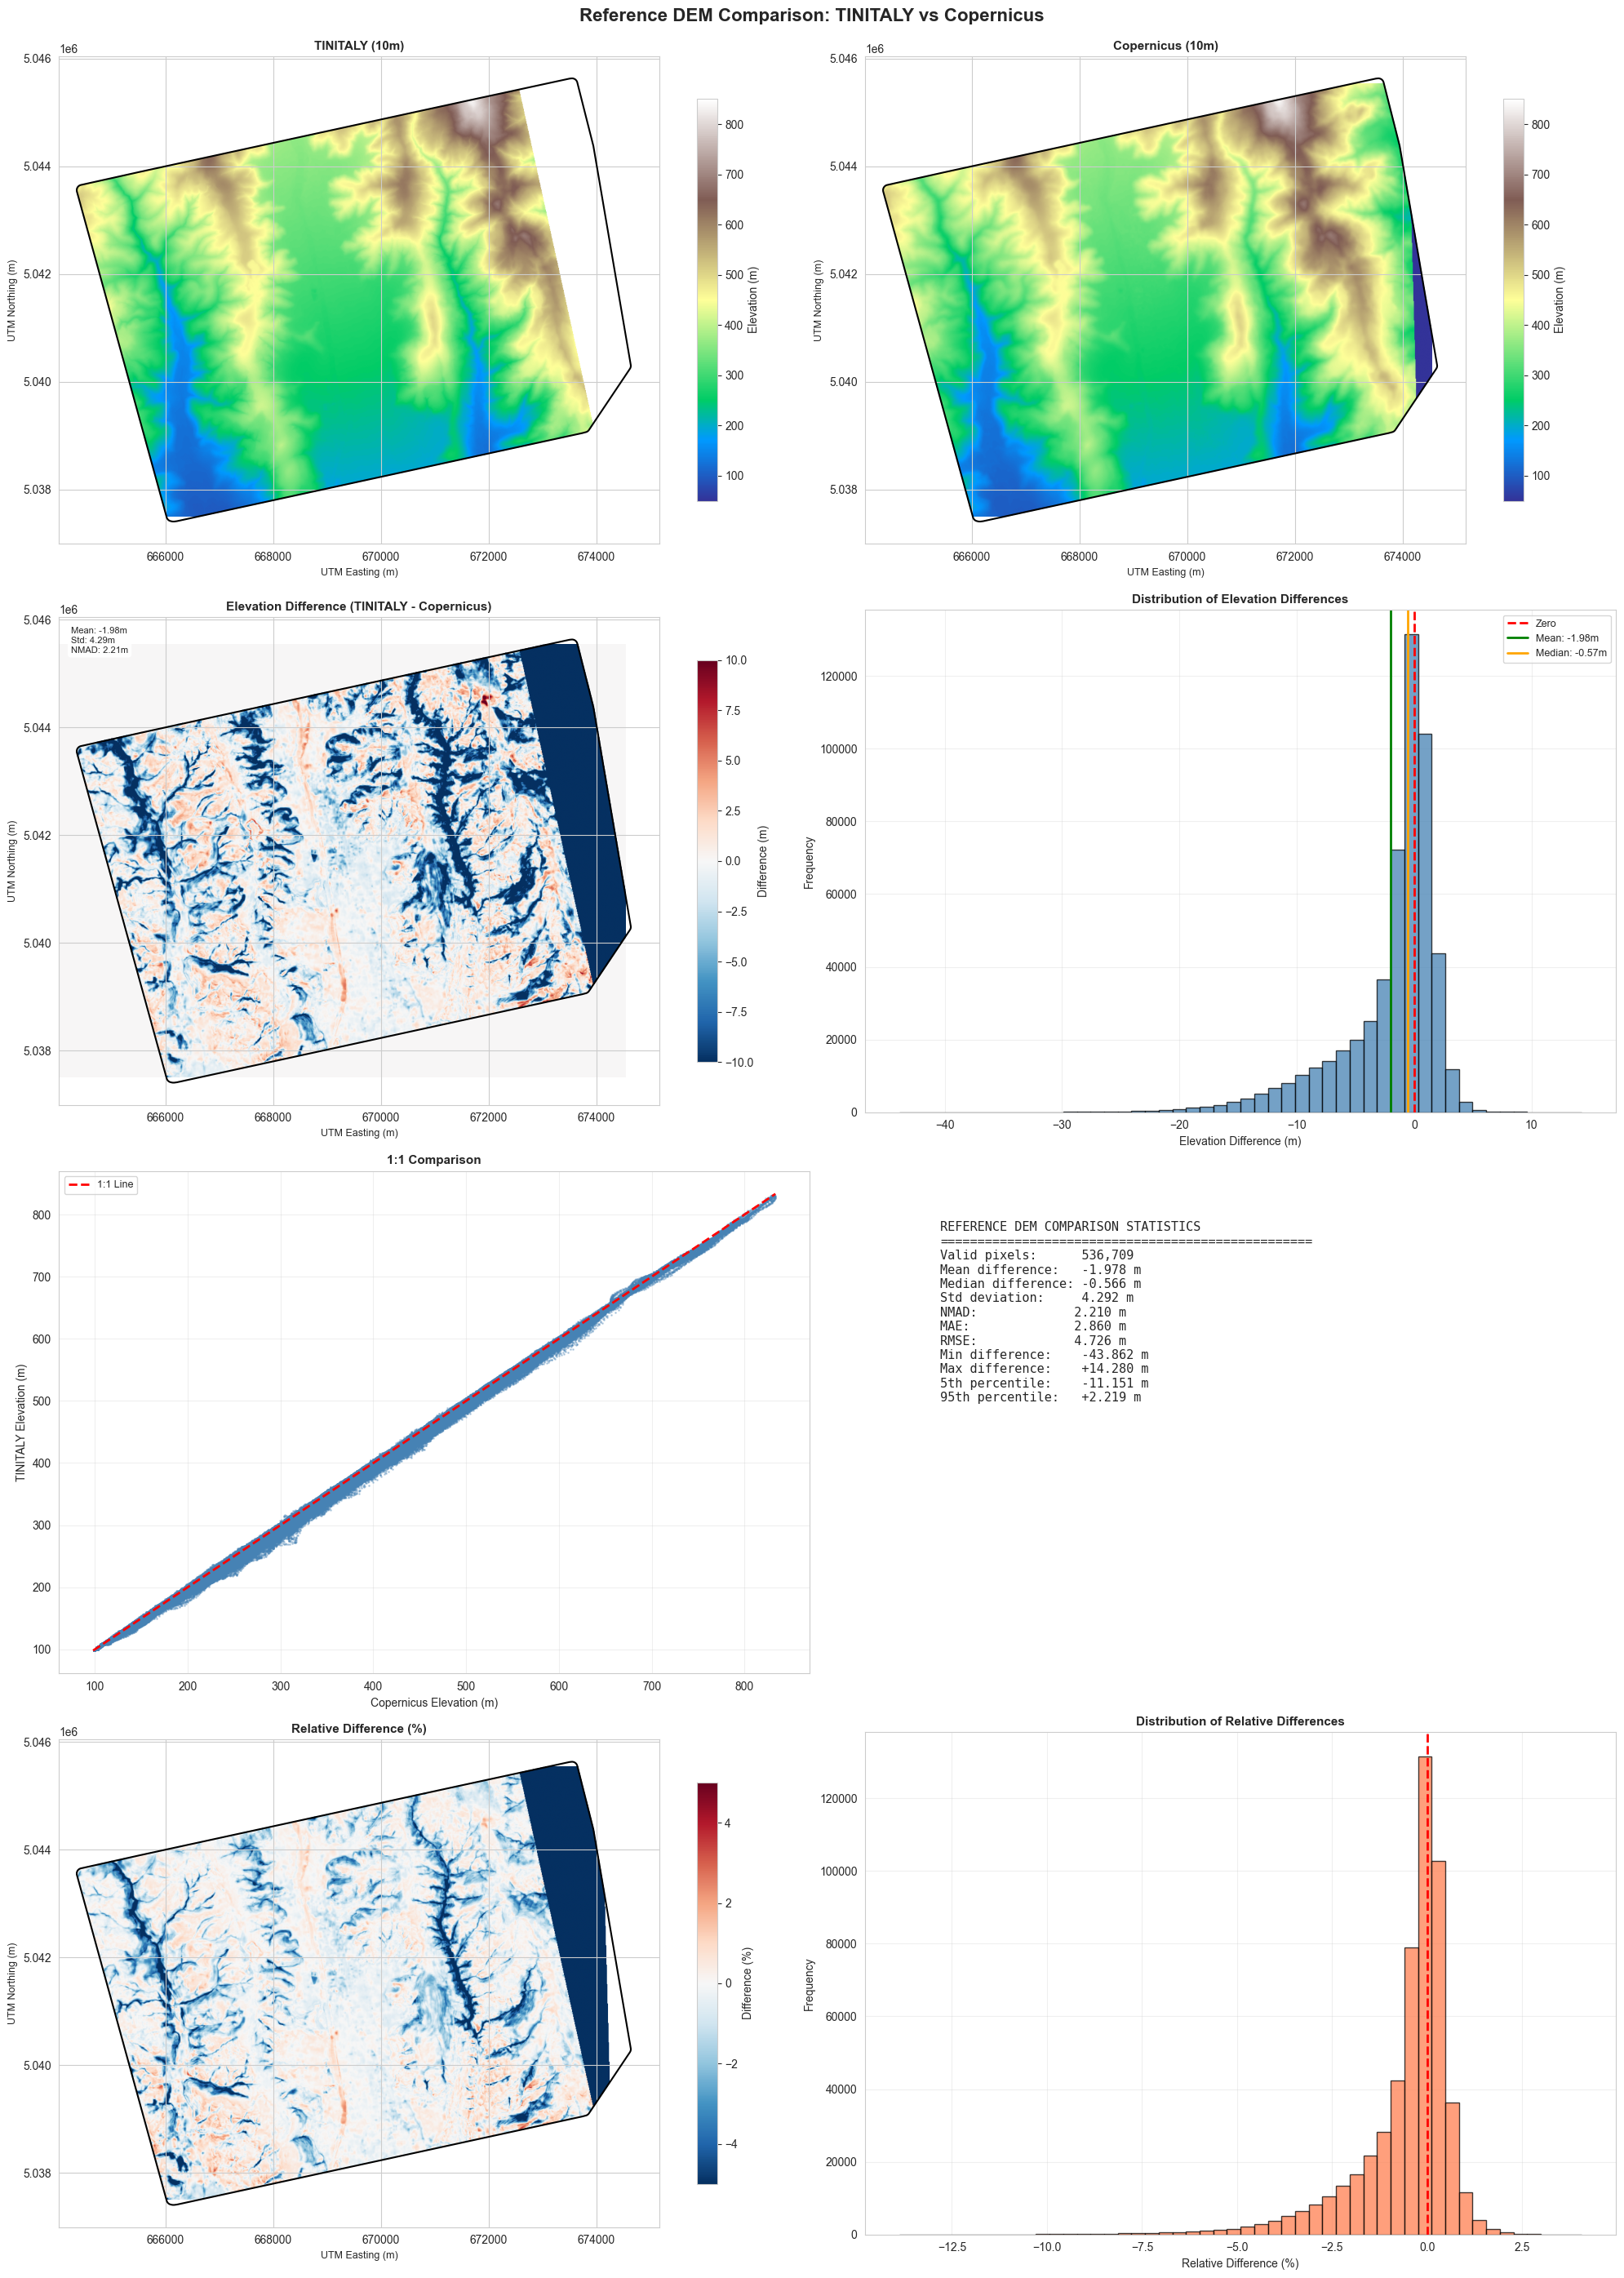

In [13]:
# Cell 12: Reference DEM Comparison Visualization
# =============================================================================
def plot_imshow(ax, data, cmap, title, cbar_label, vlims=None, stats_arr=None):
    """Helper for consistent imshow plots."""
    ax.set_facecolor('white')
    if data is tinitaly_data or data is copernicus_data:
        disp = np.ma.masked_equal(data, NODATA)
    else:
        disp = np.ma.masked_invalid(data)
    
    cm = cmap.copy()
    cm.set_bad(color='white', alpha=0)
    
    vmin, vmax = vlims if vlims else (np.nanmin(data), np.nanmax(data))
    im = ax.imshow(disp, extent=[xmin_grid, xmax_grid, ymin_grid, ymax_grid],
                   cmap=cm, vmin=vmin, vmax=vmax, origin='upper')
    
    hull_gdf.boundary.plot(ax=ax, color='black', linewidth=1.5)
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xlabel('UTM Easting (m)', fontsize=9)
    ax.set_ylabel('UTM Northing (m)', fontsize=9)
    
    cbar = plt.colorbar(im, ax=ax, label=cbar_label, shrink=0.8)
    
    if stats_arr is not None:
        stats_text = (f"Mean: {np.nanmean(stats_arr):+.2f}m\n"
                     f"Std: {np.nanstd(stats_arr):.2f}m\n"
                     f"NMAD: {calculate_nmad(pd.Series(stats_arr[np.isfinite(stats_arr)])):.2f}m")
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=8,
               va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

fig, axes = plt.subplots(4, 2, figsize=(20, 28), facecolor='white')
extent = [xmin_grid, xmax_grid, ymin_grid, ymax_grid]

# Row 1: Raw DEMs
plot_imshow(axes[0,0], tinitaly_data, plt.cm.terrain, 'TINITALY (10m)', 
           'Elevation (m)', vlims=(50, 850))
plot_imshow(axes[0,1], copernicus_data, plt.cm.terrain, 'Copernicus (10m)', 
           'Elevation (m)', vlims=(50, 850))

# Row 2: Elevation difference
plot_imshow(axes[1,0], elevation_diff, plt.cm.RdBu_r, 
           'Elevation Difference (TINITALY - Copernicus)', 
           'Difference (m)', vlims=(-10, 10), stats_arr=valid_diffs)

# Histogram
axes[1,1].set_facecolor('white')
axes[1,1].hist(valid_diffs, bins=50, color='steelblue', alpha=0.75, edgecolor='black')
axes[1,1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
axes[1,1].axvline(ref_stats['mean_diff'], color='green', linestyle='-', 
                 linewidth=2, label=f"Mean: {ref_stats['mean_diff']:+.2f}m")
axes[1,1].axvline(ref_stats['median_diff'], color='orange', linestyle='-', 
                 linewidth=2, label=f"Median: {ref_stats['median_diff']:+.2f}m")
axes[1,1].set_xlabel('Elevation Difference (m)', fontsize=10)
axes[1,1].set_ylabel('Frequency', fontsize=10)
axes[1,1].set_title('Distribution of Elevation Differences', fontsize=11, fontweight='bold')
axes[1,1].legend(fontsize=9)
axes[1,1].grid(True, alpha=0.3)

# Row 3: Scatter plot
axes[2,0].set_facecolor('white')
axes[2,0].scatter(valid_copernicus, valid_tinitaly, s=1, alpha=0.3, c='steelblue')
lims = [min(valid_copernicus.min(), valid_tinitaly.min()),
        max(valid_copernicus.max(), valid_tinitaly.max())]
axes[2,0].plot(lims, lims, 'r--', linewidth=2, label='1:1 Line')
axes[2,0].set_xlabel('Copernicus Elevation (m)', fontsize=10)
axes[2,0].set_ylabel('TINITALY Elevation (m)', fontsize=10)
axes[2,0].set_title('1:1 Comparison', fontsize=11, fontweight='bold')
axes[2,0].legend(fontsize=9)
axes[2,0].grid(True, alpha=0.3)

# Statistics table
axes[2,1].axis('off')
stats_text = "REFERENCE DEM COMPARISON STATISTICS\n" + "="*50 + "\n"
stats_text += f"Valid pixels:      {ref_stats['n_pixels']:,}\n"
stats_text += f"Mean difference:   {ref_stats['mean_diff']:+.3f} m\n"
stats_text += f"Median difference: {ref_stats['median_diff']:+.3f} m\n"
stats_text += f"Std deviation:     {ref_stats['std_diff']:.3f} m\n"
stats_text += f"NMAD:             {ref_stats['nmad']:.3f} m\n"
stats_text += f"MAE:              {ref_stats['mae']:.3f} m\n"
stats_text += f"RMSE:             {ref_stats['rmse']:.3f} m\n"
stats_text += f"Min difference:    {ref_stats['min_diff']:+.3f} m\n"
stats_text += f"Max difference:    {ref_stats['max_diff']:+.3f} m\n"
stats_text += f"5th percentile:    {ref_stats['q05']:+.3f} m\n"
stats_text += f"95th percentile:   {ref_stats['q95']:+.3f} m\n"
axes[2,1].text(0.1, 0.9, stats_text, transform=axes[2,1].transAxes,
              fontsize=11, va='top', fontfamily='monospace')

# Row 4: Relative difference percentage
rel_diff = np.where(copernicus_data != NODATA,
                    100 * (tinitaly_data - copernicus_data) / copernicus_data,
                    np.nan)
plot_imshow(axes[3,0], rel_diff, plt.cm.RdBu_r, 
           'Relative Difference (%)', 'Difference (%)', vlims=(-5, 5))

# Area-weighted histogram
axes[3,1].set_facecolor('white')
rel_valid = rel_diff[valid_mask]
axes[3,1].hist(rel_valid, bins=50, color='coral', alpha=0.75, edgecolor='black')
axes[3,1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[3,1].set_xlabel('Relative Difference (%)', fontsize=10)
axes[3,1].set_ylabel('Frequency', fontsize=10)
axes[3,1].set_title('Distribution of Relative Differences', fontsize=11, fontweight='bold')
axes[3,1].grid(True, alpha=0.3)

plt.suptitle('Reference DEM Comparison: TINITALY vs Copernicus', 
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'reference_dem_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================


In [14]:
# Cell 12: Sample CORINE at SAOCOM Locations (Using Cleaned Data)
# =============================================================================
xs, ys = saocom_gdf.geometry.x.values, saocom_gdf.geometry.y.values
r, c = rowcol(target_transform, xs, ys)
inb = (r >= 0) & (r < grid_height) & (c >= 0) & (c < grid_width)

saocom_corine = np.full(len(saocom_gdf), 0, dtype=np.uint16)
saocom_corine[inb] = corine_10m[r[inb], c[inb]]

saocom_gdf['corine_code'] = saocom_corine
saocom_gdf['corine_label'] = saocom_gdf['corine_code'].map(
    lambda x: code_to_label.get(x, 'Unknown') if x > 0 else 'No Data')

# Land cover analysis dataframe
saocom_lc_analysis = saocom_gdf[
    (saocom_gdf['corine_code'] > 0) & 
    (saocom_gdf['diff_tinitaly'].notna())
].copy()

print(f"\nSAOCOM points with land cover data: {len(saocom_lc_analysis):,}")

# Per-class statistics
def get_clc_level1(code: int) -> str:
    """Map CLC Level 3 code to Level 1 category."""
    if 100 <= code < 200:
        return 'Urban'
    elif 200 <= code < 300:
        return 'Agricultural'
    elif 300 <= code < 400:
        return 'Forest/Natural'
    elif 400 <= code < 500:
        return 'Wetlands'
    elif 500 <= code < 600:
        return 'Water'
    return 'Other'

saocom_lc_analysis['lc_level1'] = saocom_lc_analysis['corine_code'].apply(get_clc_level1)

lc_stats = []
for lc_code in sorted(saocom_lc_analysis['corine_code'].unique()):
    subset = saocom_lc_analysis[saocom_lc_analysis['corine_code'] == lc_code]
    residuals = subset['diff_tinitaly'].dropna()
    
    if len(residuals) > 0:
        lc_stats.append({
            'code': lc_code,
            'label': code_to_label.get(lc_code, 'Unknown'),
            'level1': get_clc_level1(lc_code),
            'n_points': len(residuals),
            'mean_residual': residuals.mean(),
            'median_residual': residuals.median(),
            'std_residual': residuals.std(),
            'nmad': calculate_nmad(residuals),
            'rmse': np.sqrt((residuals**2).mean()),
            'mean_coherence': subset['COHER'].mean()
        })

lc_stats_df = pd.DataFrame(lc_stats).sort_values('n_points', ascending=False)
print(f"\nLand cover classes analyzed: {len(lc_stats_df)}")
print(lc_stats_df.head(10))




SAOCOM points with land cover data: 68,115

Land cover classes analyzed: 10
   code    label          level1  n_points  mean_residual  median_residual  \
1   221  Unknown    Agricultural     22142     265.674036           259.30   
6   311  Unknown  Forest/Natural     14977     372.966769           382.80   
5   243  Unknown    Agricultural     12166     368.908359           381.50   
3   231  Unknown    Agricultural      6169     484.006776           504.90   
0   112  Unknown           Urban      5113     249.204850           283.50   
4   242  Unknown    Agricultural      2485     351.702857           349.80   
2   223  Unknown    Agricultural      1927     224.788012           220.60   
9   331  Unknown  Forest/Natural      1610     275.424286           271.45   
7   312  Unknown  Forest/Natural      1264     412.528639           421.60   
8   313  Unknown  Forest/Natural       262     555.006107           566.25   

   std_residual       nmad        rmse  mean_coherence  
1     8

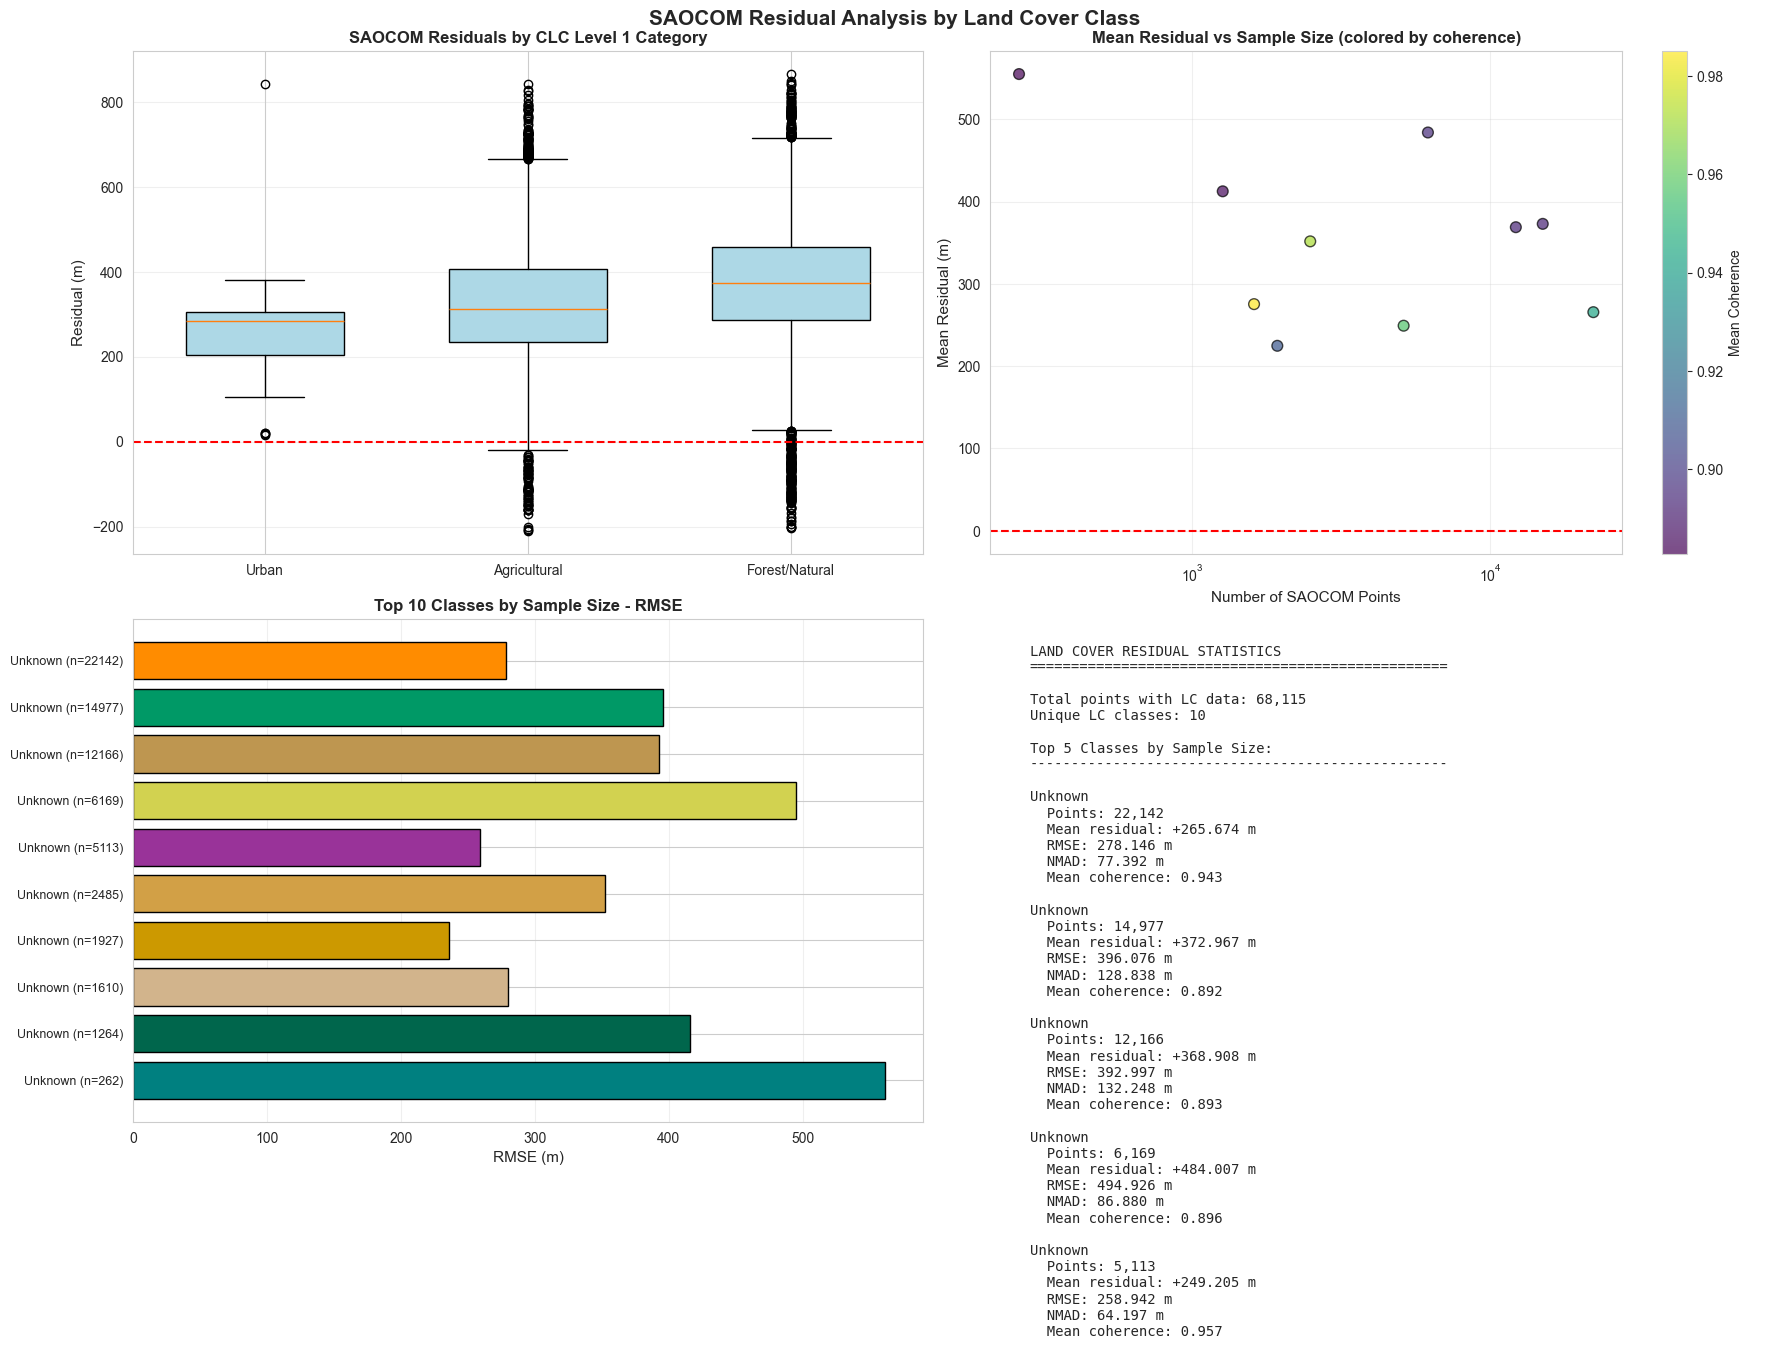

In [15]:
# Cell 13: Land Cover Residual Analysis Visualization
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(18, 14), facecolor='white')

# 1) Box plot by Level 1 category
ax1 = axes[0, 0]
ax1.set_facecolor('white')
level1_order = ['Urban', 'Agricultural', 'Forest/Natural', 'Wetlands', 'Water']
level1_data = [saocom_lc_analysis[saocom_lc_analysis['lc_level1'] == cat]['diff_tinitaly'].dropna()
               for cat in level1_order if cat in saocom_lc_analysis['lc_level1'].values]
bp1 = ax1.boxplot(level1_data, labels=[cat for cat in level1_order 
                  if cat in saocom_lc_analysis['lc_level1'].values],
                 patch_artist=True, widths=0.6)
for patch in bp1['boxes']:
    patch.set_facecolor('lightblue')
ax1.axhline(0, color='red', linestyle='--', linewidth=1.5)
ax1.set_ylabel('Residual (m)', fontsize=11)
ax1.set_title('SAOCOM Residuals by CLC Level 1 Category', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# 2) Scatter: Mean residual vs N points
ax2 = axes[0, 1]
ax2.set_facecolor('white')
sc = ax2.scatter(lc_stats_df['n_points'], lc_stats_df['mean_residual'],
                c=lc_stats_df['mean_coherence'], s=60, cmap='viridis',
                alpha=0.7, edgecolors='black')
ax2.axhline(0, color='red', linestyle='--', linewidth=1.5)
ax2.set_xlabel('Number of SAOCOM Points', fontsize=11)
ax2.set_ylabel('Mean Residual (m)', fontsize=11)
ax2.set_title('Mean Residual vs Sample Size (colored by coherence)', 
             fontsize=12, fontweight='bold')
ax2.set_xscale('log')
ax2.grid(True, alpha=0.3)
plt.colorbar(sc, ax=ax2, label='Mean Coherence')

# 3) Bar chart: Top classes by RMSE
ax3 = axes[1, 0]
ax3.set_facecolor('white')
top_classes = lc_stats_df.nlargest(10, 'n_points')
colors = [CORINE_COLORS_MPL.get(code, (0.5, 0.5, 0.5)) for code in top_classes['code']]
ax3.barh(range(len(top_classes)), top_classes['rmse'], color=colors, edgecolor='black')
ax3.set_yticks(range(len(top_classes)))
ax3.set_yticklabels([f"{row['label']} (n={row['n_points']})" 
                     for _, row in top_classes.iterrows()], fontsize=9)
ax3.set_xlabel('RMSE (m)', fontsize=11)
ax3.set_title('Top 10 Classes by Sample Size - RMSE', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')
ax3.invert_yaxis()

# 4) Statistics summary
ax4 = axes[1, 1]
ax4.axis('off')
summary_text = "LAND COVER RESIDUAL STATISTICS\n" + "="*50 + "\n\n"
summary_text += f"Total points with LC data: {len(saocom_lc_analysis):,}\n"
summary_text += f"Unique LC classes: {len(lc_stats_df)}\n\n"
summary_text += "Top 5 Classes by Sample Size:\n" + "-"*50 + "\n"
for i, row in lc_stats_df.head(5).iterrows():
    summary_text += f"\n{row['label']}\n"
    summary_text += f"  Points: {row['n_points']:,}\n"
    summary_text += f"  Mean residual: {row['mean_residual']:+.3f} m\n"
    summary_text += f"  RMSE: {row['rmse']:.3f} m\n"
    summary_text += f"  NMAD: {row['nmad']:.3f} m\n"
    summary_text += f"  Mean coherence: {row['mean_coherence']:.3f}\n"
ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes,
        fontsize=10, va='top', fontfamily='monospace')

plt.suptitle('SAOCOM Residual Analysis by Land Cover Class', 
            fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'landcover_residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()



In [16]:
# Cell 14: SAOCOM vs Reference DEM Comparison Metrics
# =============================================================================
def calculate_comparison_metrics(saocom_heights: np.ndarray, 
                                ref_heights: np.ndarray) -> Dict:
    """Calculate comprehensive comparison metrics."""
    valid = np.isfinite(saocom_heights) & np.isfinite(ref_heights)
    
    if valid.sum() < 10:
        return {'n_points': 0, 'mean_diff': np.nan, 'rmse': np.nan}
    
    s, r = saocom_heights[valid], ref_heights[valid]
    diff = s - r
    
    return {
        'n_points': int(valid.sum()),
        'mean_diff': float(diff.mean()),
        'median_diff': float(np.median(diff)),
        'std_diff': float(diff.std()),
        'nmad': calculate_nmad(pd.Series(diff)),
        'mae': float(np.abs(diff).mean()),
        'rmse': float(np.sqrt((diff**2).mean())),
        'min_diff': float(diff.min()),
        'max_diff': float(diff.max()),
        'q05': float(np.percentile(diff, 5)),
        'q95': float(np.percentile(diff, 95)),
        'r2': float(np.corrcoef(s, r)[0, 1]**2) if len(s) > 1 else np.nan
    }

# Calculate metrics for both comparisons
valid_elevation_range = (50, 850)

tin_mask = (saocom_gdf['HEIGHT_ABSOLUTE_TIN'].notna() & 
            saocom_gdf['tinitaly_height'].notna() &
            (saocom_gdf['HEIGHT_ABSOLUTE_TIN'] >= valid_elevation_range[0]) &
            (saocom_gdf['HEIGHT_ABSOLUTE_TIN'] <= valid_elevation_range[1]))

cop_mask = (saocom_gdf['HEIGHT_ABSOLUTE_COP'].notna() & 
            saocom_gdf['copernicus_height'].notna() &
            (saocom_gdf['HEIGHT_ABSOLUTE_COP'] >= valid_elevation_range[0]) &
            (saocom_gdf['HEIGHT_ABSOLUTE_COP'] <= valid_elevation_range[1]))

saocom_tinitaly_metrics = calculate_comparison_metrics(
    saocom_gdf.loc[tin_mask, 'HEIGHT_ABSOLUTE_TIN'].values,
    saocom_gdf.loc[tin_mask, 'tinitaly_height'].values
)

saocom_copernicus_metrics = calculate_comparison_metrics(
    saocom_gdf.loc[cop_mask, 'HEIGHT_ABSOLUTE_COP'].values,
    saocom_gdf.loc[cop_mask, 'copernicus_height'].values
)

print(f"\n{'='*70}")
print(f"SAOCOM vs TINITALY Comparison")
print(f"{'='*70}")
for k, v in saocom_tinitaly_metrics.items():
    if k == 'n_points':
        print(f"{k:<15}: {v:,}")
    else:
        print(f"{k:<15}: {v:+.3f}" + (" m" if 'diff' in k or 'mae' in k or 'rmse' in k else ""))

print(f"\n{'='*70}")
print(f"SAOCOM vs Copernicus Comparison")
print(f"{'='*70}")
for k, v in saocom_copernicus_metrics.items():
    if k == 'n_points':
        print(f"{k:<15}: {v:,}")
    else:
        print(f"{k:<15}: {v:+.3f}" + (" m" if 'diff' in k or 'mae' in k or 'rmse' in k else ""))




SAOCOM vs TINITALY Comparison
n_points       : 51,612
mean_diff      : +276.551 m
median_diff    : +283.400 m
std_diff       : +85.938 m
nmad           : +92.069
mae            : +277.427 m
rmse           : +289.596 m
min_diff       : -210.000 m
max_diff       : +629.600 m
q05            : +125.200
q95            : +403.945
r2             : +0.889

SAOCOM vs Copernicus Comparison
n_points       : 51,441
mean_diff      : +276.057 m
median_diff    : +283.000 m
std_diff       : +85.650 m
nmad           : +91.773
mae            : +276.936 m
rmse           : +289.039 m
min_diff       : -210.000 m
max_diff       : +629.600 m
q05            : +125.100
q95            : +402.800
r2             : +0.888


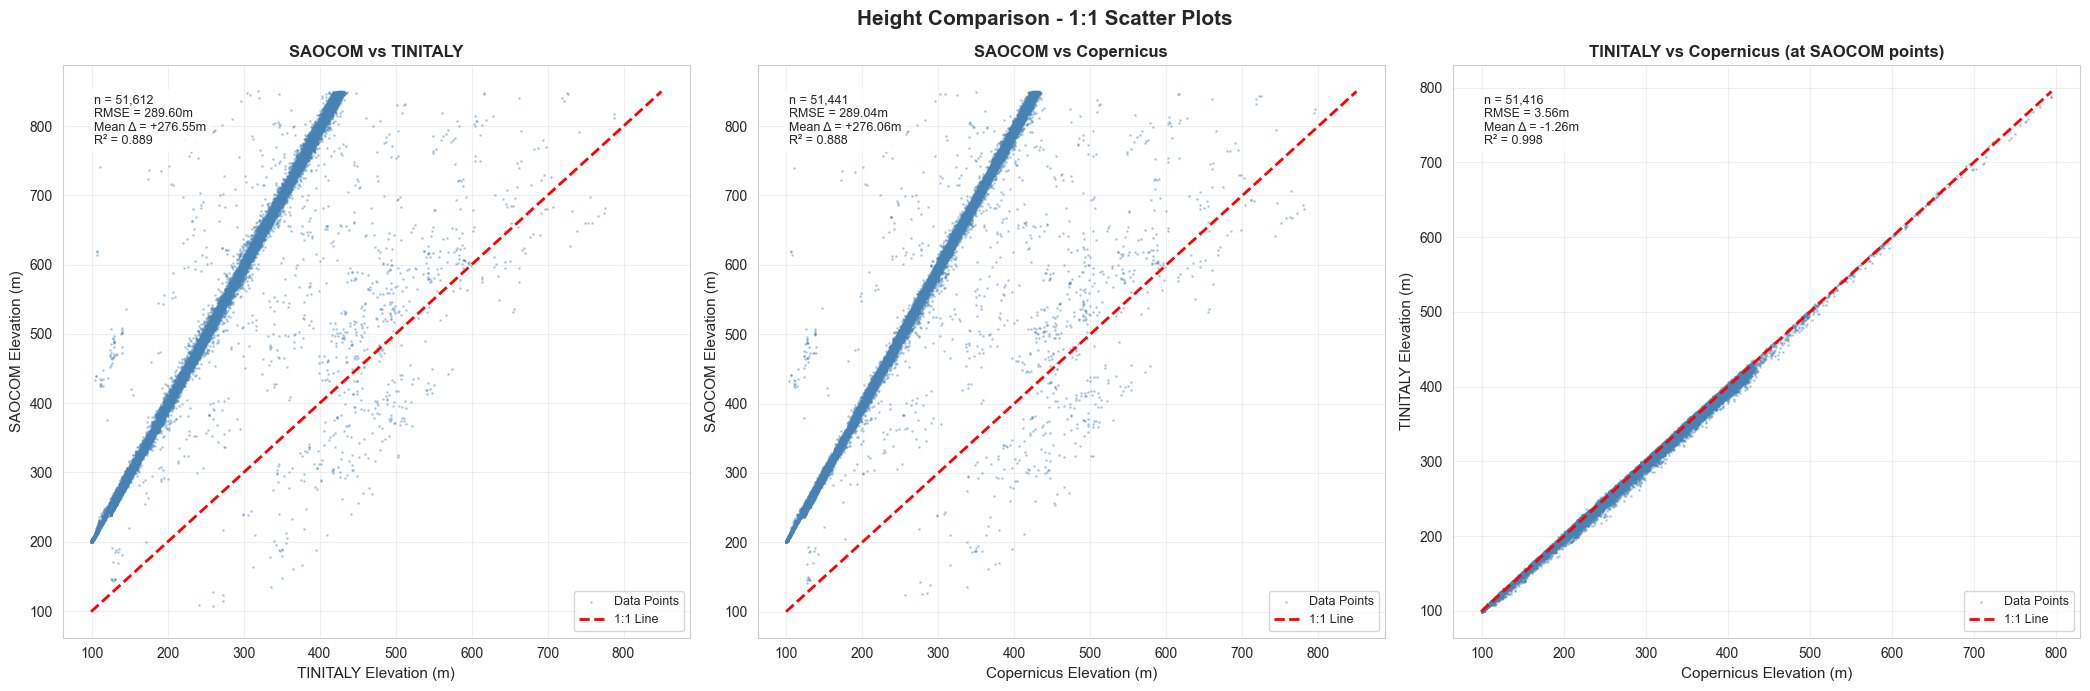

In [17]:
# Cell 15: SAOCOM Comparison Scatter Plots
# =============================================================================
def plot_scatter_comparison(ax, x_data, y_data, x_label, y_label, title, stats):
    """Create 1:1 scatter plot with statistics."""
    ax.set_facecolor('white')
    ax.scatter(x_data, y_data, s=1, alpha=0.3, c='steelblue', label='Data Points')
    
    lims = [min(x_data.min(), y_data.min()), max(x_data.max(), y_data.max())]
    ax.plot(lims, lims, 'r--', linewidth=2, label='1:1 Line')
    
    ax.set_xlabel(x_label, fontsize=11)
    ax.set_ylabel(y_label, fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    stats_text = (f"n = {stats['n_points']:,}\n"
                 f"RMSE = {stats['rmse']:.2f}m\n"
                 f"Mean Δ = {stats['mean_diff']:+.2f}m\n"
                 f"R² = {stats['r2']:.3f}")
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=9,
           va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

fig, axes = plt.subplots(1, 3, figsize=(21, 7), facecolor='white')

# 1) SAOCOM vs TINITALY
tin_valid = saocom_gdf[tin_mask]
plot_scatter_comparison(
    axes[0],
    tin_valid['tinitaly_height'].values,
    tin_valid['HEIGHT_ABSOLUTE_TIN'].values,
    'TINITALY Elevation (m)',
    'SAOCOM Elevation (m)',
    'SAOCOM vs TINITALY',
    saocom_tinitaly_metrics
)

# 2) SAOCOM vs Copernicus
cop_valid = saocom_gdf[cop_mask]
plot_scatter_comparison(
    axes[1],
    cop_valid['copernicus_height'].values,
    cop_valid['HEIGHT_ABSOLUTE_COP'].values,
    'Copernicus Elevation (m)',
    'SAOCOM Elevation (m)',
    'SAOCOM vs Copernicus',
    saocom_copernicus_metrics
)

# 3) TINITALY vs Copernicus (at SAOCOM locations)
both_valid = tin_mask & cop_mask
if both_valid.sum() > 0:
    both_df = saocom_gdf[both_valid]
    both_metrics = calculate_comparison_metrics(
        both_df['tinitaly_height'].values,
        both_df['copernicus_height'].values
    )
    plot_scatter_comparison(
        axes[2],
        both_df['copernicus_height'].values,
        both_df['tinitaly_height'].values,
        'Copernicus Elevation (m)',
        'TINITALY Elevation (m)',
        'TINITALY vs Copernicus (at SAOCOM points)',
        both_metrics
    )

plt.suptitle('Height Comparison - 1:1 Scatter Plots', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'height_comparison_scatter.png', dpi=300, bbox_inches='tight')
plt.show()



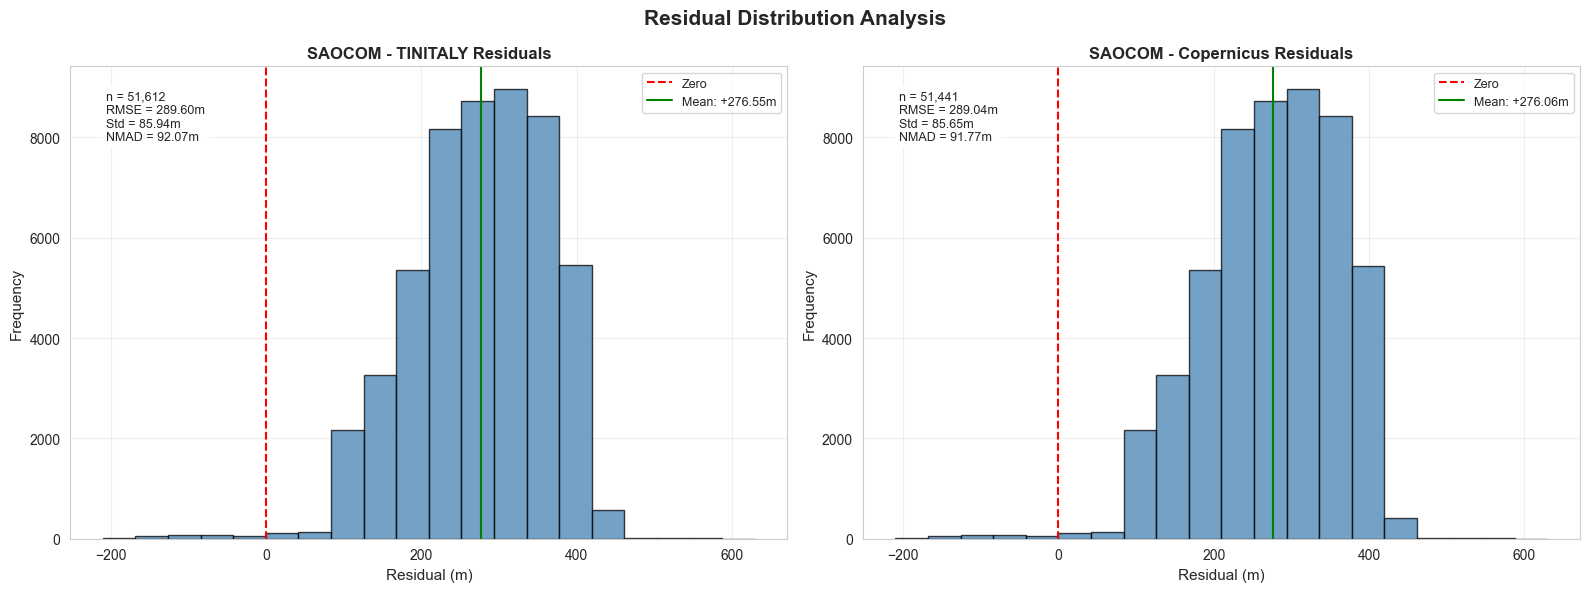

In [18]:
# Cell 16: Residual Distribution Plots
# =============================================================================
def plot_distribution(ax, diff_series, title, metrics):
    """Plot residual distribution histogram with statistics."""
    ax.set_facecolor('white')
    ax.hist(diff_series, bins=20, alpha=0.75, color='steelblue', edgecolor='black')
    ax.axvline(0, color='red', linestyle='--', label='Zero')
    ax.axvline(metrics['mean_diff'], color='green', linestyle='-', 
              label=f"Mean: {metrics['mean_diff']:+.2f}m")
    
    stats_text = (f"n = {metrics['n_points']:,}\n"
                 f"RMSE = {metrics['rmse']:.2f}m\n"
                 f"Std = {metrics['std_diff']:.2f}m\n"
                 f"NMAD = {metrics['nmad']:.2f}m")
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=9,
           va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    ax.set_xlabel('Residual (m)', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), facecolor='white')

# SAOCOM - TINITALY
tin_diffs = tin_valid['HEIGHT_ABSOLUTE_TIN'] - tin_valid['tinitaly_height']
plot_distribution(axes[0], tin_diffs, 'SAOCOM - TINITALY Residuals', 
                 saocom_tinitaly_metrics)

# SAOCOM - Copernicus
cop_diffs = cop_valid['HEIGHT_ABSOLUTE_COP'] - cop_valid['copernicus_height']
plot_distribution(axes[1], cop_diffs, 'SAOCOM - Copernicus Residuals', 
                 saocom_copernicus_metrics)

plt.suptitle('Residual Distribution Analysis', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'residual_distributions.png', dpi=300, bbox_inches='tight')
plt.show()



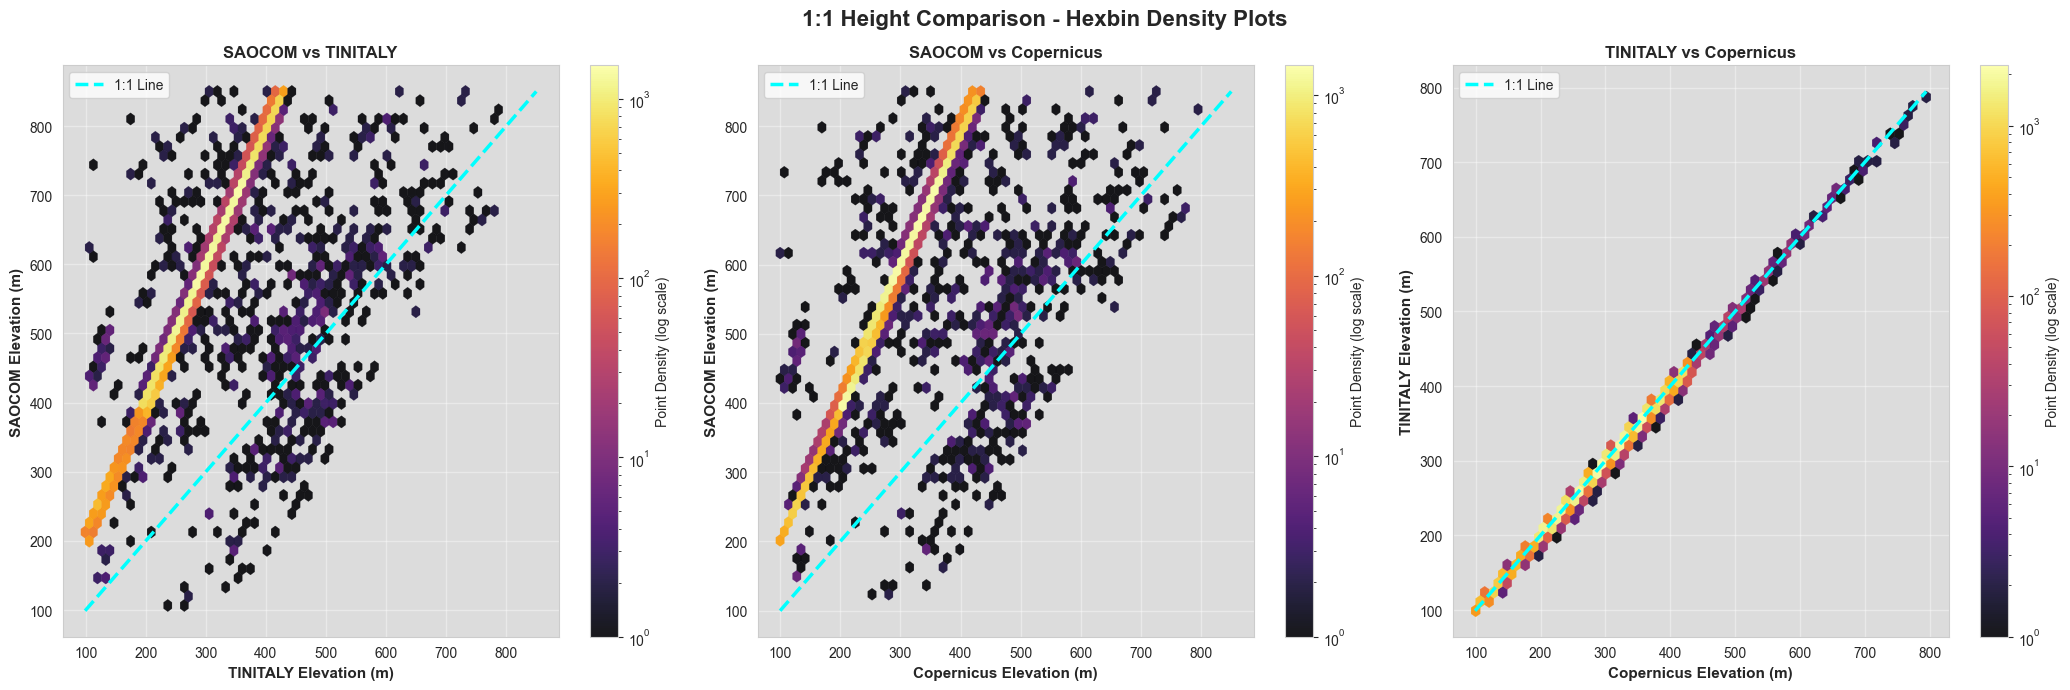

In [19]:
# Cell 17: Hexbin Density Plots
# =============================================================================
import matplotlib.colors as colors

fig, axes = plt.subplots(1, 3, figsize=(21, 7), facecolor='white')
fig.suptitle('1:1 Height Comparison - Hexbin Density Plots', fontsize=16, fontweight='bold')

def plot_hexbin(ax, x_data, y_data, x_label, y_label, title):
    """Create hexbin density plot."""
    ax.set_facecolor('gainsboro')
    
    hb = ax.hexbin(x_data, y_data, gridsize=50, cmap='inferno', 
                   norm=colors.LogNorm(), mincnt=1, linewidths=0.2, alpha=0.9)
    
    lims = [min(x_data.min(), y_data.min()), max(x_data.max(), y_data.max())]
    ax.plot(lims, lims, 'cyan', linestyle='--', linewidth=2.5, label='1:1 Line')
    
    ax.set_xlabel(x_label, fontsize=11, fontweight='bold')
    ax.set_ylabel(y_label, fontsize=11, fontweight='bold')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.legend(fontsize=10, loc='upper left')
    ax.grid(True, alpha=0.4, color='white', linewidth=1)
    
    plt.colorbar(hb, ax=ax, label='Point Density (log scale)')

plot_hexbin(axes[0], tin_valid['tinitaly_height'], tin_valid['HEIGHT_ABSOLUTE_TIN'],
           'TINITALY Elevation (m)', 'SAOCOM Elevation (m)', 'SAOCOM vs TINITALY')
plot_hexbin(axes[1], cop_valid['copernicus_height'], cop_valid['HEIGHT_ABSOLUTE_COP'],
           'Copernicus Elevation (m)', 'SAOCOM Elevation (m)', 'SAOCOM vs Copernicus')

if both_valid.sum() > 0:
    plot_hexbin(axes[2], both_df['copernicus_height'], both_df['tinitaly_height'],
               'Copernicus Elevation (m)', 'TINITALY Elevation (m)', 
               'TINITALY vs Copernicus')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'height_comparison_hexbin.png', dpi=300, bbox_inches='tight')
plt.show()



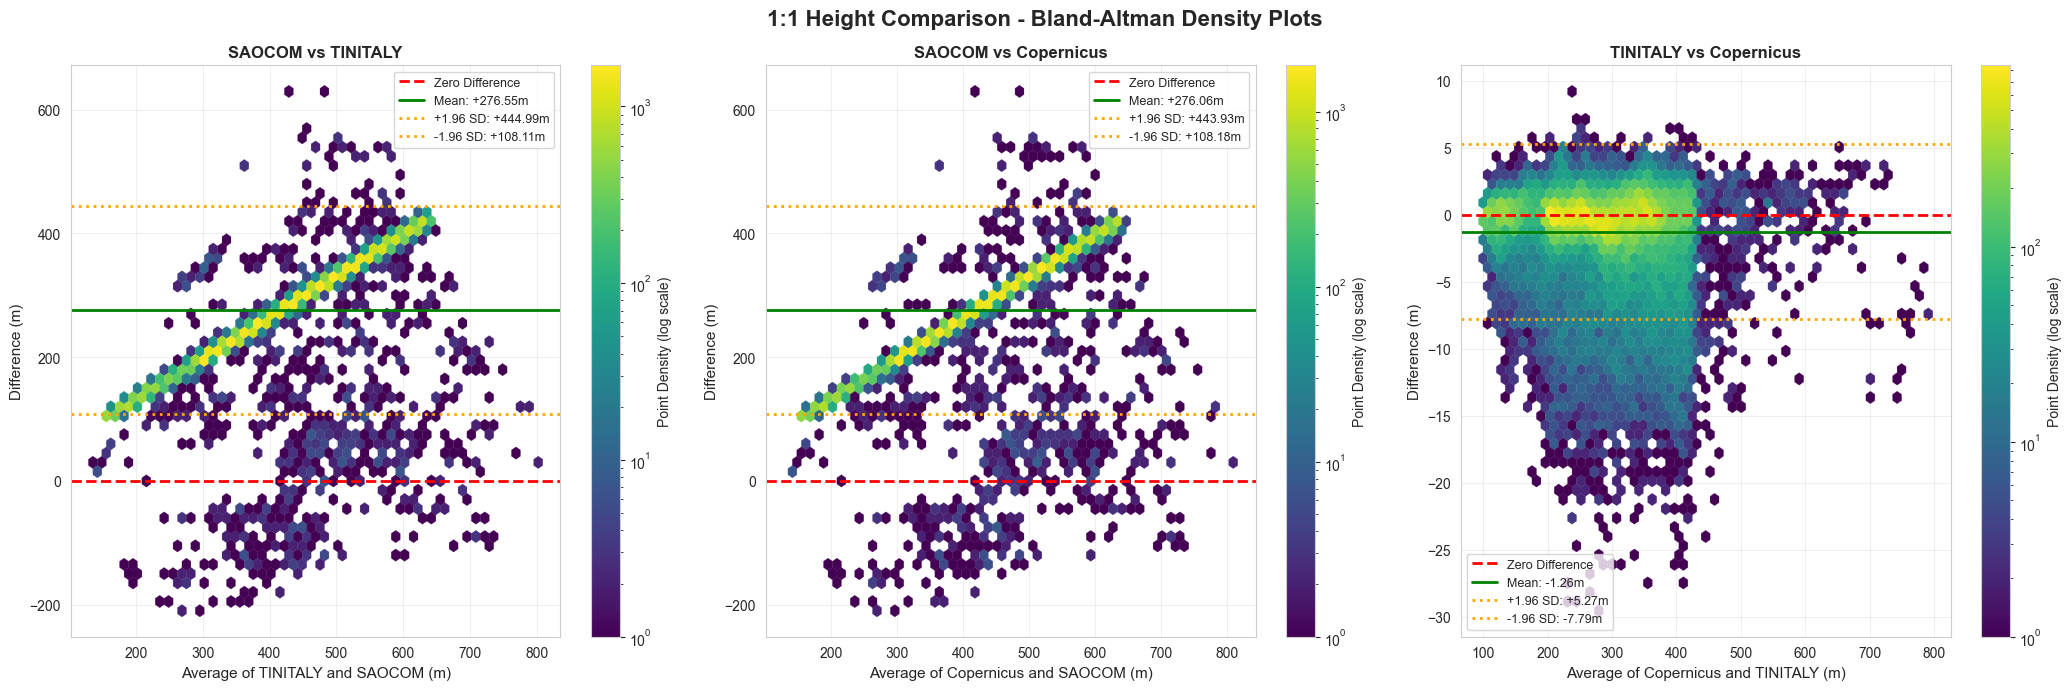

In [20]:
# Cell 18: Bland-Altman Plots
# =============================================================================
fig, axes = plt.subplots(1, 3, figsize=(21, 7), facecolor='white')
fig.suptitle('1:1 Height Comparison - Bland-Altman Density Plots', 
            fontsize=16, fontweight='bold')

def plot_bland_altman(ax, x_data, y_data, x_label, y_label, title):
    """Create Bland-Altman hexbin plot."""
    average = (x_data + y_data) / 2
    difference = y_data - x_data
    
    mean_diff = difference.mean()
    std_diff = difference.std()
    
    hb = ax.hexbin(average, difference, gridsize=50, cmap='viridis',
                   norm=colors.LogNorm(), mincnt=1, linewidths=0.2)
    
    ax.axhline(0, color='red', linestyle='--', linewidth=2, label='Zero Difference')
    ax.axhline(mean_diff, color='green', linestyle='-', linewidth=2,
              label=f'Mean: {mean_diff:+.2f}m')
    ax.axhline(mean_diff + 1.96*std_diff, color='orange', linestyle=':', linewidth=2,
              label=f'+1.96 SD: {mean_diff + 1.96*std_diff:+.2f}m')
    ax.axhline(mean_diff - 1.96*std_diff, color='orange', linestyle=':', linewidth=2,
              label=f'-1.96 SD: {mean_diff - 1.96*std_diff:+.2f}m')
    
    ax.set_xlabel(f'Average of {x_label} and {y_label} (m)', fontsize=11)
    ax.set_ylabel('Difference (m)', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.colorbar(hb, ax=ax, label='Point Density (log scale)')

plot_bland_altman(axes[0], tin_valid['tinitaly_height'], tin_valid['HEIGHT_ABSOLUTE_TIN'],
                 'TINITALY', 'SAOCOM', 'SAOCOM vs TINITALY')
plot_bland_altman(axes[1], cop_valid['copernicus_height'], cop_valid['HEIGHT_ABSOLUTE_COP'],
                 'Copernicus', 'SAOCOM', 'SAOCOM vs Copernicus')

if both_valid.sum() > 0:
    plot_bland_altman(axes[2], both_df['copernicus_height'], both_df['tinitaly_height'],
                     'Copernicus', 'TINITALY', 'TINITALY vs Copernicus')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'height_comparison_bland_altman.png', dpi=300, bbox_inches='tight')
plt.show()



In [21]:
# Cell 19: Void Zone Analysis by Land Cover
# =============================================================================
void_lc_stats = []

for lc_code in np.unique(corine_10m[corine_10m > 0]):
    lc_mask = corine_10m == lc_code
    lc_total = lc_mask & hull_mask
    lc_void = lc_mask & void_mask
    lc_saocom = lc_mask & saocom_coverage & hull_mask
    
    total_pixels = lc_total.sum()
    void_pixels = lc_void.sum()
    saocom_pixels = lc_saocom.sum()
    
    if total_pixels > 0:
        void_lc_stats.append({
            'code': lc_code,
            'label': code_to_label.get(lc_code, 'Unknown'),
            'level1': get_clc_level1(lc_code),
            'total_pixels': total_pixels,
            'void_pixels': void_pixels,
            'saocom_pixels': saocom_pixels,
            'total_area_km2': total_pixels * pixel_area_km2,
            'void_area_km2': void_pixels * pixel_area_km2,
            'saocom_area_km2': saocom_pixels * pixel_area_km2,
            'void_pct': (void_pixels / total_pixels * 100) if total_pixels > 0 else 0,
            'saocom_pct': (saocom_pixels / total_pixels * 100) if total_pixels > 0 else 0
        })

void_lc_df = pd.DataFrame(void_lc_stats).sort_values('total_area_km2', ascending=False)

print(f"\n{'='*70}")
print(f"VOID ZONE ANALYSIS BY LAND COVER")
print(f"{'='*70}")
print(void_lc_df.head(10))
print(f"{'='*70}\n")




VOID ZONE ANALYSIS BY LAND COVER
   code    label          level1  total_pixels  void_pixels  saocom_pixels  \
6   311  Unknown  Forest/Natural        176226       161783          14443   
1   221  Unknown    Agricultural        152845       131505          21340   
5   243  Unknown    Agricultural        146841       135025          11816   
3   231  Unknown    Agricultural         43550        37614           5936   
0   112  Unknown           Urban         22300        17415           4885   
4   242  Unknown    Agricultural         15642        13246           2396   
2   223  Unknown    Agricultural         15099        13228           1871   
7   312  Unknown  Forest/Natural          9201         8001           1200   
9   331  Unknown  Forest/Natural          8016         6469           1547   
8   313  Unknown  Forest/Natural          3097         2843            254   

   total_area_km2  void_area_km2  saocom_area_km2   void_pct  saocom_pct  
6         17.6226        16.1783

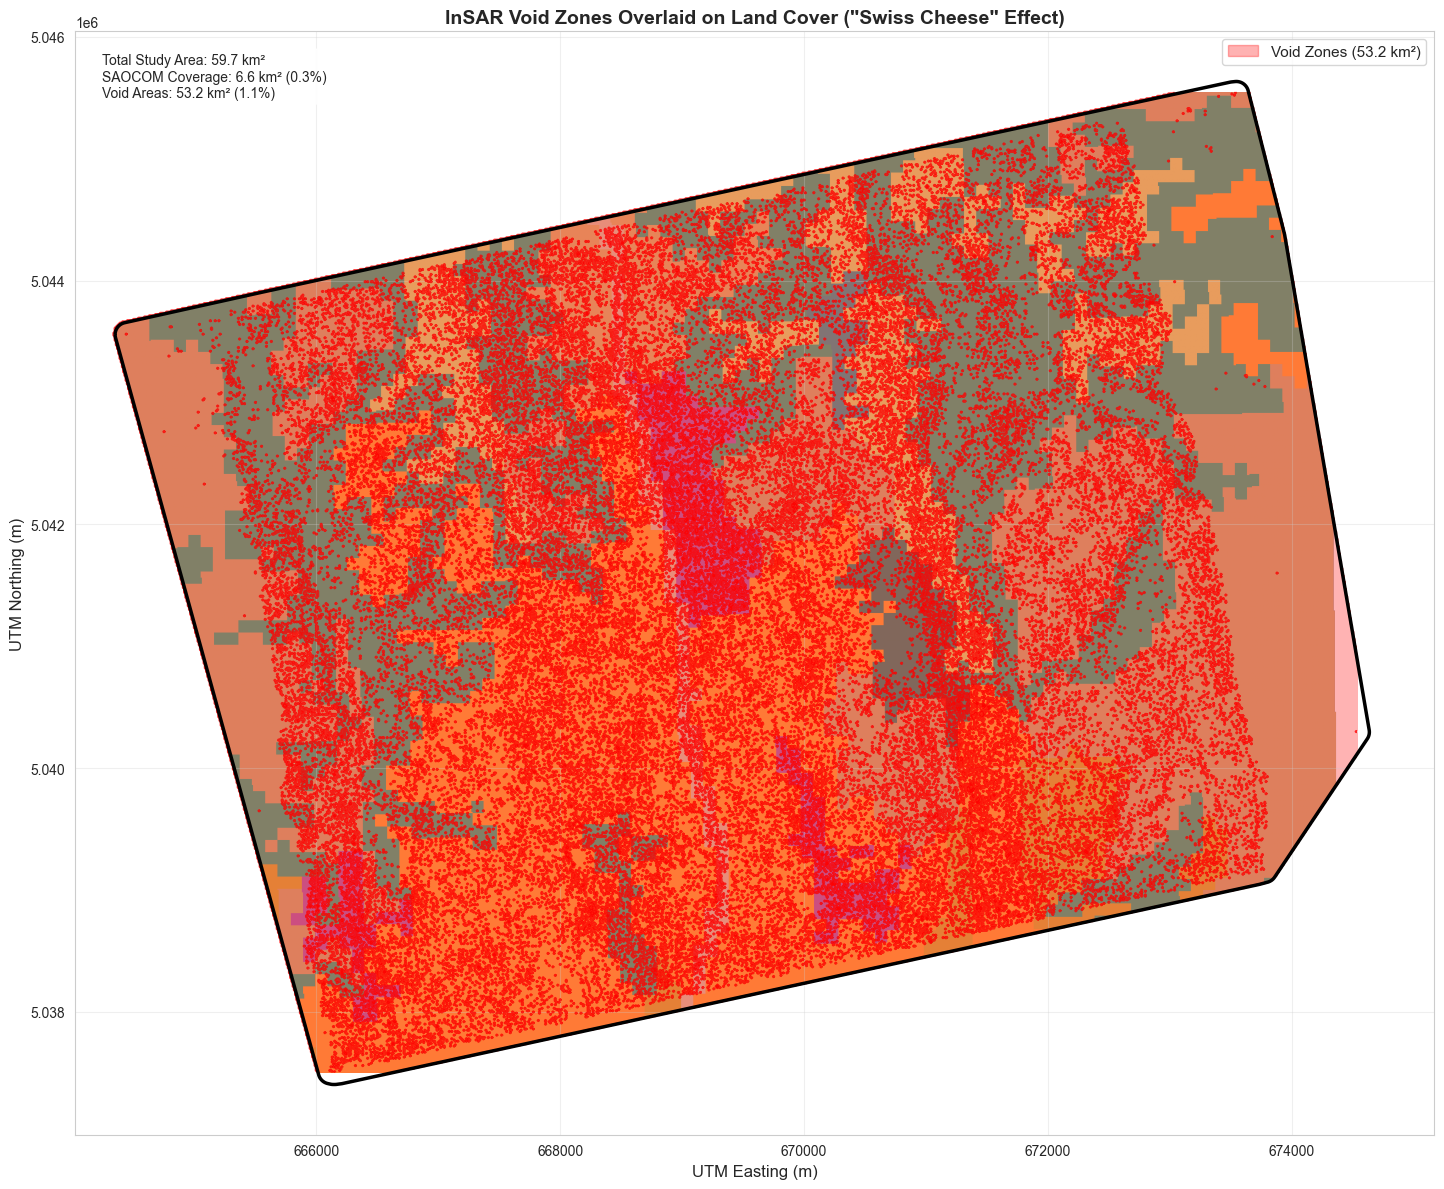

In [22]:
# Cell 20: Void Zone Visualization - "Swiss Cheese" Plot
# =============================================================================
from matplotlib.patches import Patch
from skimage.measure import find_contours

fig, ax = plt.subplots(1, 1, figsize=(16, 12), facecolor='white')

# Plot land cover base
lc_display = np.ma.masked_where(corine_10m == 0, corine_10m)
unique_codes = np.unique(corine_10m[corine_10m > 0])
cmap_lc = ListedColormap([CORINE_COLORS_MPL.get(c, (0.8, 0.8, 0.8)) for c in unique_codes])
norm_lc = BoundaryNorm(np.append(unique_codes, unique_codes[-1]+1) - 0.5, cmap_lc.N)

ax.imshow(lc_display, extent=[xmin_grid, xmax_grid, ymin_grid, ymax_grid],
         cmap=cmap_lc, norm=norm_lc, origin='upper', alpha=0.7)

# Overlay void zones as contours
void_display = void_mask.astype(float)
contours = find_contours(void_display, 0.5)
for contour in contours:
    rows, cols = contour[:, 0], contour[:, 1]
    xs = xmin_grid + cols * GRID_SIZE
    ys = ymax_grid - rows * GRID_SIZE
    ax.plot(xs, ys, color='red', linewidth=1.5, alpha=0.8)

# Fill void zones
void_rgba = np.zeros((*void_display.shape, 4))
void_rgba[void_mask, :] = [1, 0, 0, 0.3]  # Red with 30% alpha
ax.imshow(void_rgba, extent=[xmin_grid, xmax_grid, ymin_grid, ymax_grid], origin='upper')

hull_gdf.boundary.plot(ax=ax, color='black', linewidth=2.5, label='Study Area Hull')

ax.set_xlabel('UTM Easting (m)', fontsize=12)
ax.set_ylabel('UTM Northing (m)', fontsize=12)
ax.set_title('InSAR Void Zones Overlaid on Land Cover ("Swiss Cheese" Effect)', 
            fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

legend_elements = [
    Patch(facecolor='red', alpha=0.3, edgecolor='red', label=f'Void Zones ({void_area_km2:.1f} km²)')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=11)

stats_text = (f"Total Study Area: {study_area_km2:.1f} km²\n"
             f"SAOCOM Coverage: {saocom_area_km2:.1f} km² ({saocom_pixels/study_pixels*100:.1f}%)\n"
             f"Void Areas: {void_area_km2:.1f} km² ({void_pixels/study_pixels*100:.1f}%)")
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
       va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'void_zones_swiss_cheese.png', dpi=300, bbox_inches='tight')
plt.show()



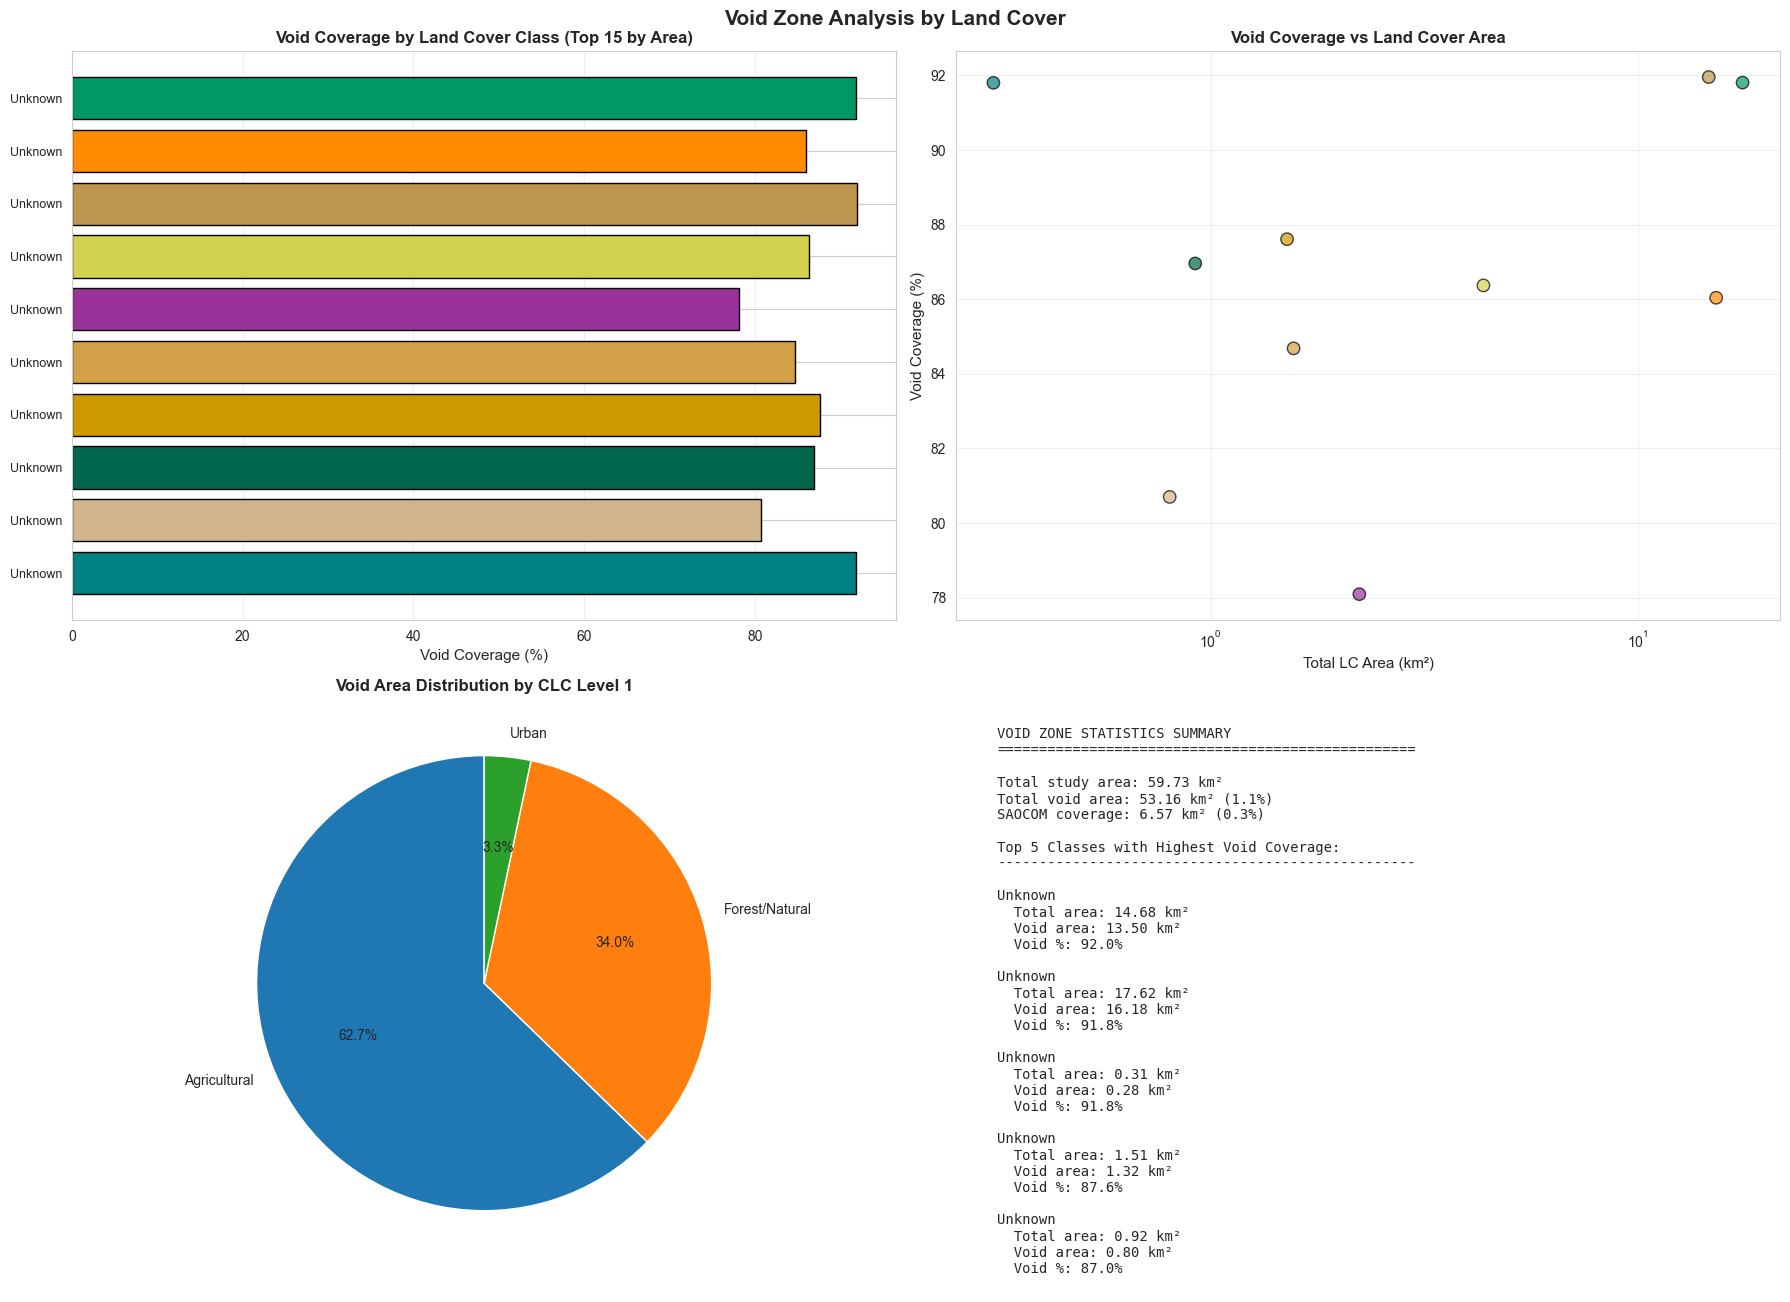

In [23]:
# Cell 21: Void Zone Summary Statistics
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(18, 14), facecolor='white')

# 1) Bar chart: Void percentage by LC class
ax1 = axes[0, 0]
ax1.set_facecolor('white')
top_void = void_lc_df.nlargest(15, 'total_area_km2')
colors_void = [CORINE_COLORS_MPL.get(code, (0.5, 0.5, 0.5)) for code in top_void['code']]
ax1.barh(range(len(top_void)), top_void['void_pct'], color=colors_void, edgecolor='black')
ax1.set_yticks(range(len(top_void)))
ax1.set_yticklabels([f"{row['label'][:30]}" for _, row in top_void.iterrows()], fontsize=9)
ax1.set_xlabel('Void Coverage (%)', fontsize=11)
ax1.set_title('Void Coverage by Land Cover Class (Top 15 by Area)', 
             fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
ax1.invert_yaxis()

# 2) Scatter: Total area vs void percentage
ax2 = axes[0, 1]
ax2.set_facecolor('white')
sc = ax2.scatter(void_lc_df['total_area_km2'], void_lc_df['void_pct'],
                c=[CORINE_COLORS_MPL.get(c, (0.5, 0.5, 0.5)) for c in void_lc_df['code']],
                s=80, alpha=0.7, edgecolors='black')
ax2.set_xlabel('Total LC Area (km²)', fontsize=11)
ax2.set_ylabel('Void Coverage (%)', fontsize=11)
ax2.set_title('Void Coverage vs Land Cover Area', fontsize=12, fontweight='bold')
ax2.set_xscale('log')
ax2.grid(True, alpha=0.3)

# 3) Pie chart: Void area by Level 1 category
ax3 = axes[1, 0]
level1_void = void_lc_df.groupby('level1')['void_area_km2'].sum().sort_values(ascending=False)
ax3.pie(level1_void, labels=level1_void.index, autopct='%1.1f%%', startangle=90)
ax3.set_title('Void Area Distribution by CLC Level 1', fontsize=12, fontweight='bold')

# 4) Statistics table
ax4 = axes[1, 1]
ax4.axis('off')
table_text = "VOID ZONE STATISTICS SUMMARY\n" + "="*50 + "\n\n"
table_text += f"Total study area: {study_area_km2:.2f} km²\n"
table_text += f"Total void area: {void_area_km2:.2f} km² ({void_pixels/study_pixels*100:.1f}%)\n"
table_text += f"SAOCOM coverage: {saocom_area_km2:.2f} km² ({saocom_pixels/study_pixels*100:.1f}%)\n\n"
table_text += "Top 5 Classes with Highest Void Coverage:\n" + "-"*50 + "\n"
for _, row in void_lc_df.nlargest(5, 'void_pct').iterrows():
    table_text += f"\n{row['label']}\n"
    table_text += f"  Total area: {row['total_area_km2']:.2f} km²\n"
    table_text += f"  Void area: {row['void_area_km2']:.2f} km²\n"
    table_text += f"  Void %: {row['void_pct']:.1f}%\n"
ax4.text(0.05, 0.95, table_text, transform=ax4.transAxes,
        fontsize=10, va='top', fontfamily='monospace')

plt.suptitle('Void Zone Analysis by Land Cover', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'void_zone_statistics.png', dpi=300, bbox_inches='tight')
plt.show()



In [24]:
# Cell 22: Topographic Analysis - Calculate Slope and Aspect
# =============================================================================
def calculate_slope_aspect(dem: np.ndarray, pixel_size: float = GRID_SIZE) -> Tuple[np.ndarray, np.ndarray]:
    """Calculate slope (degrees) and aspect (degrees) from DEM."""
    # Gradient calculation
    dy, dx = np.gradient(dem, pixel_size)
    
    # Slope in degrees
    slope = np.degrees(np.arctan(np.sqrt(dx**2 + dy**2)))
    
    # Aspect in degrees (0-360, 0=North, clockwise)
    aspect = np.degrees(np.arctan2(-dx, dy))
    aspect = (aspect + 360) % 360
    
    # Mask invalid values
    invalid = (dem == NODATA) | ~np.isfinite(dem)
    slope[invalid] = np.nan
    aspect[invalid] = np.nan
    
    return slope, aspect

print("Calculating topographic derivatives...")

# Calculate for both DEMs
tinitaly_slope, tinitaly_aspect = calculate_slope_aspect(tinitaly_10m)
copernicus_slope, copernicus_aspect = calculate_slope_aspect(copernicus_10m)

# Sample at SAOCOM locations
saocom_gdf['slope_tinitaly'] = sample_raster_at_points(tinitaly_slope, saocom_gdf, target_transform)
saocom_gdf['aspect_tinitaly'] = sample_raster_at_points(tinitaly_aspect, saocom_gdf, target_transform)
saocom_gdf['slope_copernicus'] = sample_raster_at_points(copernicus_slope, saocom_gdf, target_transform)
saocom_gdf['aspect_copernicus'] = sample_raster_at_points(copernicus_aspect, saocom_gdf, target_transform)

print("Topographic derivatives calculated successfully")



Calculating topographic derivatives...
Topographic derivatives calculated successfully


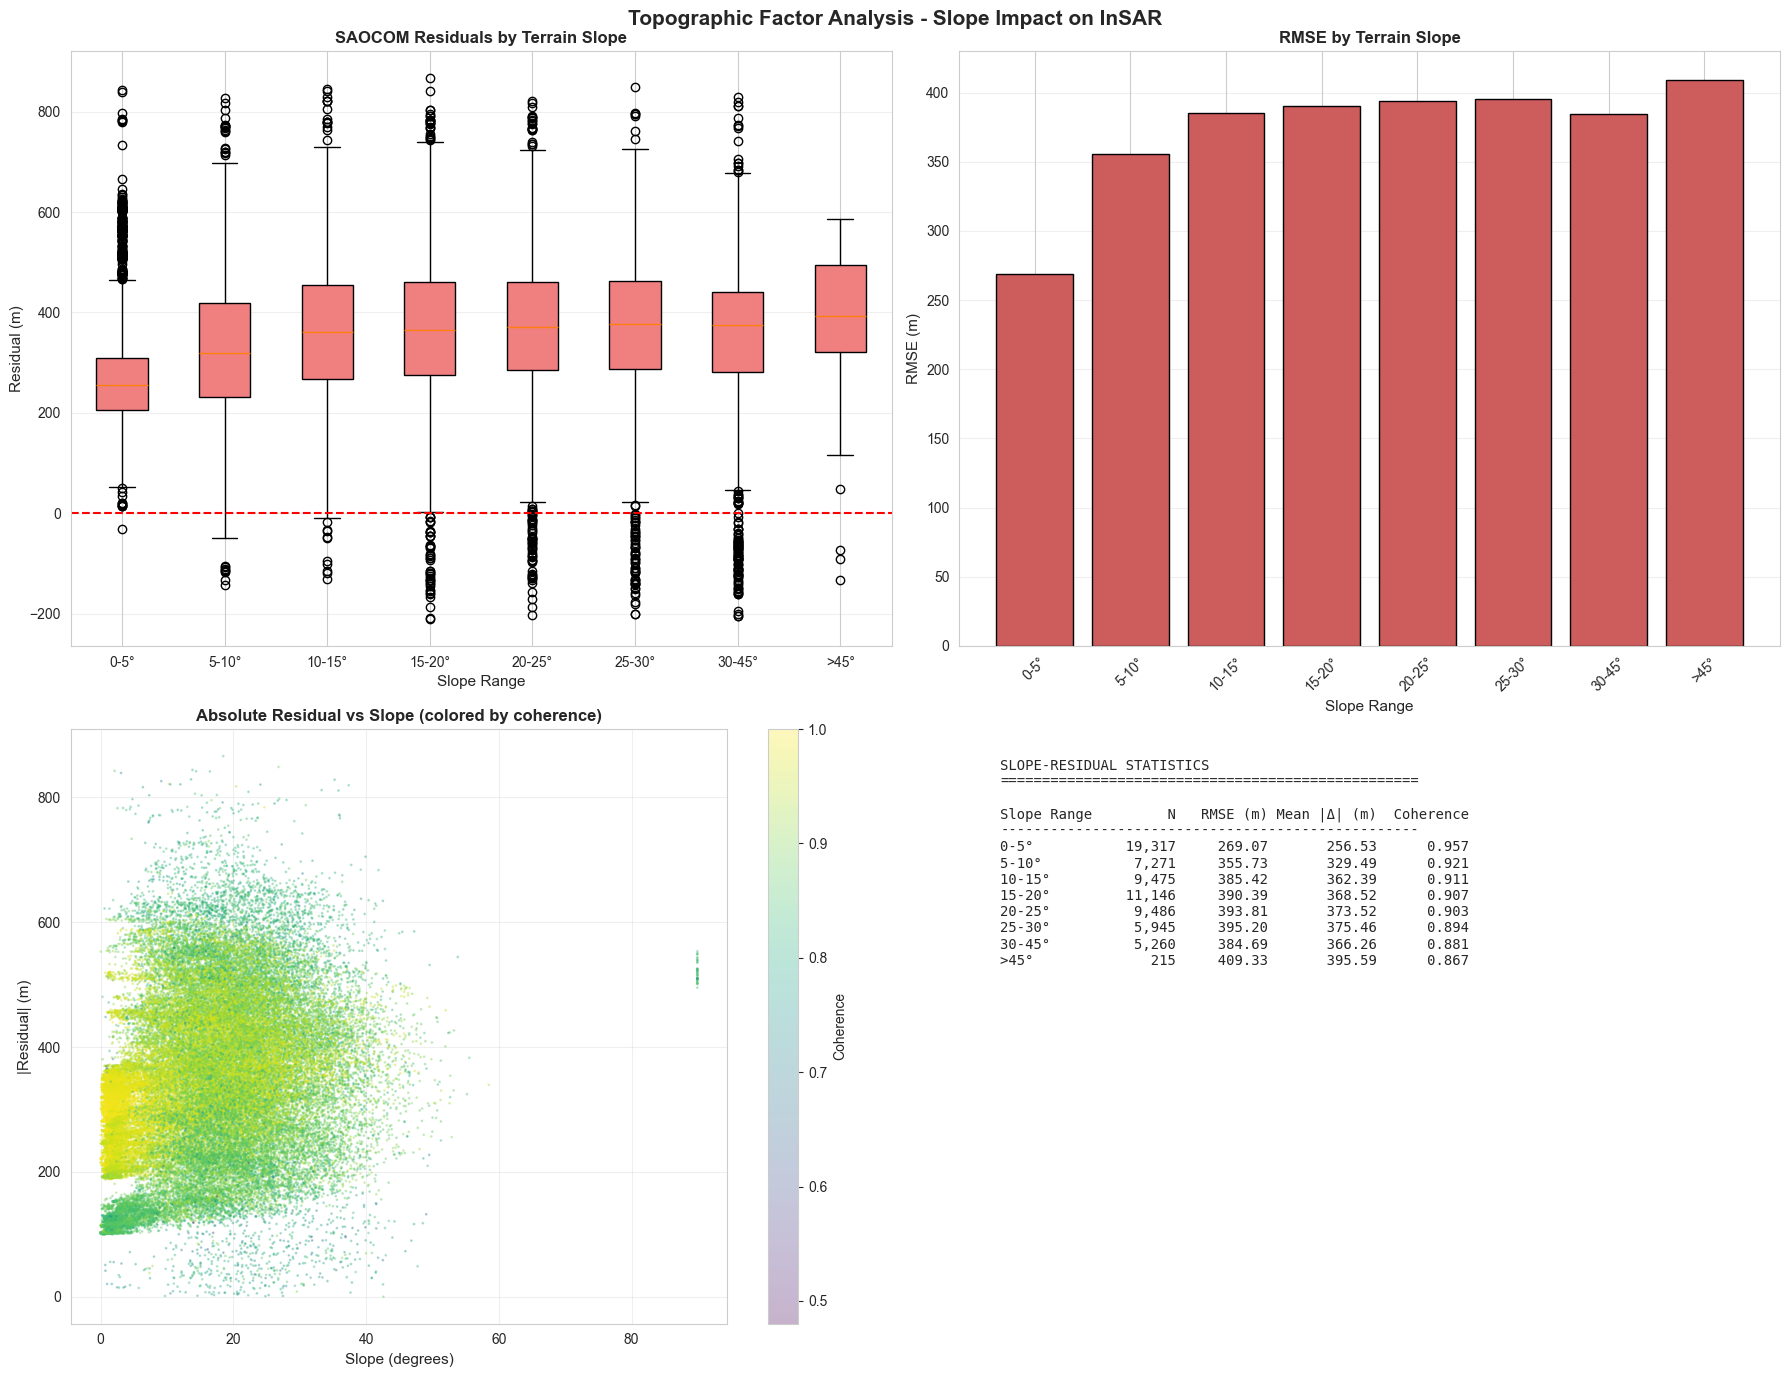

In [25]:
# Cell 23: Topographic Factor Analysis
# =============================================================================
# Slope-residual analysis
valid_slope_tin = (saocom_gdf['slope_tinitaly'].notna() & 
                   saocom_gdf['diff_tinitaly'].notna())

slope_bins = [0, 5, 10, 15, 20, 25, 30, 45, 90]
slope_labels = ['0-5°', '5-10°', '10-15°', '15-20°', '20-25°', '25-30°', '30-45°', '>45°']

saocom_gdf['slope_bin'] = pd.cut(saocom_gdf['slope_tinitaly'], bins=slope_bins, 
                                  labels=slope_labels, include_lowest=True)

slope_stats = []
for bin_label in slope_labels:
    subset = saocom_gdf[(saocom_gdf['slope_bin'] == bin_label) & valid_slope_tin]
    if len(subset) > 0:
        residuals = subset['diff_tinitaly']
        slope_stats.append({
            'slope_range': bin_label,
            'n_points': len(residuals),
            'mean_residual': residuals.mean(),
            'median_residual': residuals.median(),
            'std_residual': residuals.std(),
            'rmse': np.sqrt((residuals**2).mean()),
            'mean_abs_residual': np.abs(residuals).mean(),
            'mean_coherence': subset['COHER'].mean()
        })

slope_stats_df = pd.DataFrame(slope_stats)

fig, axes = plt.subplots(2, 2, figsize=(18, 14), facecolor='white')

# 1) Box plot: Residuals by slope bin
ax1 = axes[0, 0]
ax1.set_facecolor('white')
slope_data = [saocom_gdf[(saocom_gdf['slope_bin'] == label) & valid_slope_tin]['diff_tinitaly'].values
              for label in slope_labels if len(saocom_gdf[(saocom_gdf['slope_bin'] == label) & valid_slope_tin]) > 0]
slope_labels_plot = [label for label in slope_labels 
                     if len(saocom_gdf[(saocom_gdf['slope_bin'] == label) & valid_slope_tin]) > 0]
bp = ax1.boxplot(slope_data, labels=slope_labels_plot, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightcoral')
ax1.axhline(0, color='red', linestyle='--', linewidth=1.5)
ax1.set_xlabel('Slope Range', fontsize=11)
ax1.set_ylabel('Residual (m)', fontsize=11)
ax1.set_title('SAOCOM Residuals by Terrain Slope', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# 2) Bar chart: RMSE by slope
ax2 = axes[0, 1]
ax2.set_facecolor('white')
ax2.bar(range(len(slope_stats_df)), slope_stats_df['rmse'], 
       color='indianred', edgecolor='black')
ax2.set_xticks(range(len(slope_stats_df)))
ax2.set_xticklabels(slope_stats_df['slope_range'], rotation=45)
ax2.set_xlabel('Slope Range', fontsize=11)
ax2.set_ylabel('RMSE (m)', fontsize=11)
ax2.set_title('RMSE by Terrain Slope', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# 3) Scatter: Slope vs absolute residual
ax3 = axes[1, 0]
ax3.set_facecolor('white')
valid_plot = saocom_gdf[valid_slope_tin].copy()
sc = ax3.scatter(valid_plot['slope_tinitaly'], np.abs(valid_plot['diff_tinitaly']),
                c=valid_plot['COHER'], s=1, alpha=0.3, cmap='viridis')
ax3.set_xlabel('Slope (degrees)', fontsize=11)
ax3.set_ylabel('|Residual| (m)', fontsize=11)
ax3.set_title('Absolute Residual vs Slope (colored by coherence)', 
             fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
plt.colorbar(sc, ax=ax3, label='Coherence')

# 4) Statistics table
ax4 = axes[1, 1]
ax4.axis('off')
table_text = "SLOPE-RESIDUAL STATISTICS\n" + "="*50 + "\n\n"
table_text += f"{'Slope Range':<12} {'N':>8} {'RMSE (m)':>10} {'Mean |Δ| (m)':>12} {'Coherence':>10}\n"
table_text += "-"*50 + "\n"
for _, row in slope_stats_df.iterrows():
    table_text += f"{row['slope_range']:<12} {row['n_points']:>8,} {row['rmse']:>10.2f} "
    table_text += f"{row['mean_abs_residual']:>12.2f} {row['mean_coherence']:>10.3f}\n"
ax4.text(0.05, 0.95, table_text, transform=ax4.transAxes,
        fontsize=10, va='top', fontfamily='monospace')

plt.suptitle('Topographic Factor Analysis - Slope Impact on InSAR', 
            fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'topographic_slope_analysis.png', dpi=300, bbox_inches='tight')
plt.show()



In [26]:
# Cell 24: Terrain Suitability Assessment
# =============================================================================
def calculate_suitability_index(slope: np.ndarray, aspect: np.ndarray, 
                               elevation: np.ndarray) -> np.ndarray:
    """Calculate InSAR terrain suitability index (0-1)."""
    # Slope factor (ideal: 0-10°, unsuitable: >45°)
    slope_score = np.where(slope <= 5, 1.0,
                  np.where(slope <= 15, 0.8,
                  np.where(slope <= 30, 0.5,
                  np.where(slope <= 45, 0.2, 0.0))))
    
    # Aspect factor (north-facing slopes: 315-45° are problematic in northern hemisphere)
    aspect_score = np.where((aspect >= 315) | (aspect <= 45), 0.7, 1.0)
    
    # Combined suitability
    suitability = slope_score * aspect_score
    
    return suitability

def classify_terrain_suitability(suitability: np.ndarray) -> np.ndarray:
    """Classify suitability index into discrete classes (0-4)."""
    classes = np.zeros_like(suitability, dtype=np.uint8)
    classes[suitability >= 0.8] = 4  # Excellent
    classes[(suitability >= 0.6) & (suitability < 0.8)] = 3  # Good
    classes[(suitability >= 0.4) & (suitability < 0.6)] = 2  # Moderate
    classes[(suitability >= 0.2) & (suitability < 0.4)] = 1  # Poor
    classes[suitability < 0.2] = 0  # Unsuitable
    return classes

# Calculate suitability for both DEMs
tin_suitability = calculate_suitability_index(tinitaly_slope, tinitaly_aspect, tinitaly_10m)
tin_class = classify_terrain_suitability(tin_suitability)

cop_suitability = calculate_suitability_index(copernicus_slope, copernicus_aspect, copernicus_10m)
cop_class = classify_terrain_suitability(cop_suitability)

# Sample at SAOCOM locations
saocom_gdf['suitability_tin'] = sample_raster_at_points(tin_suitability, saocom_gdf, target_transform)
saocom_gdf['suitability_cop'] = sample_raster_at_points(cop_suitability, saocom_gdf, target_transform)




Processing DEM: TINITALY


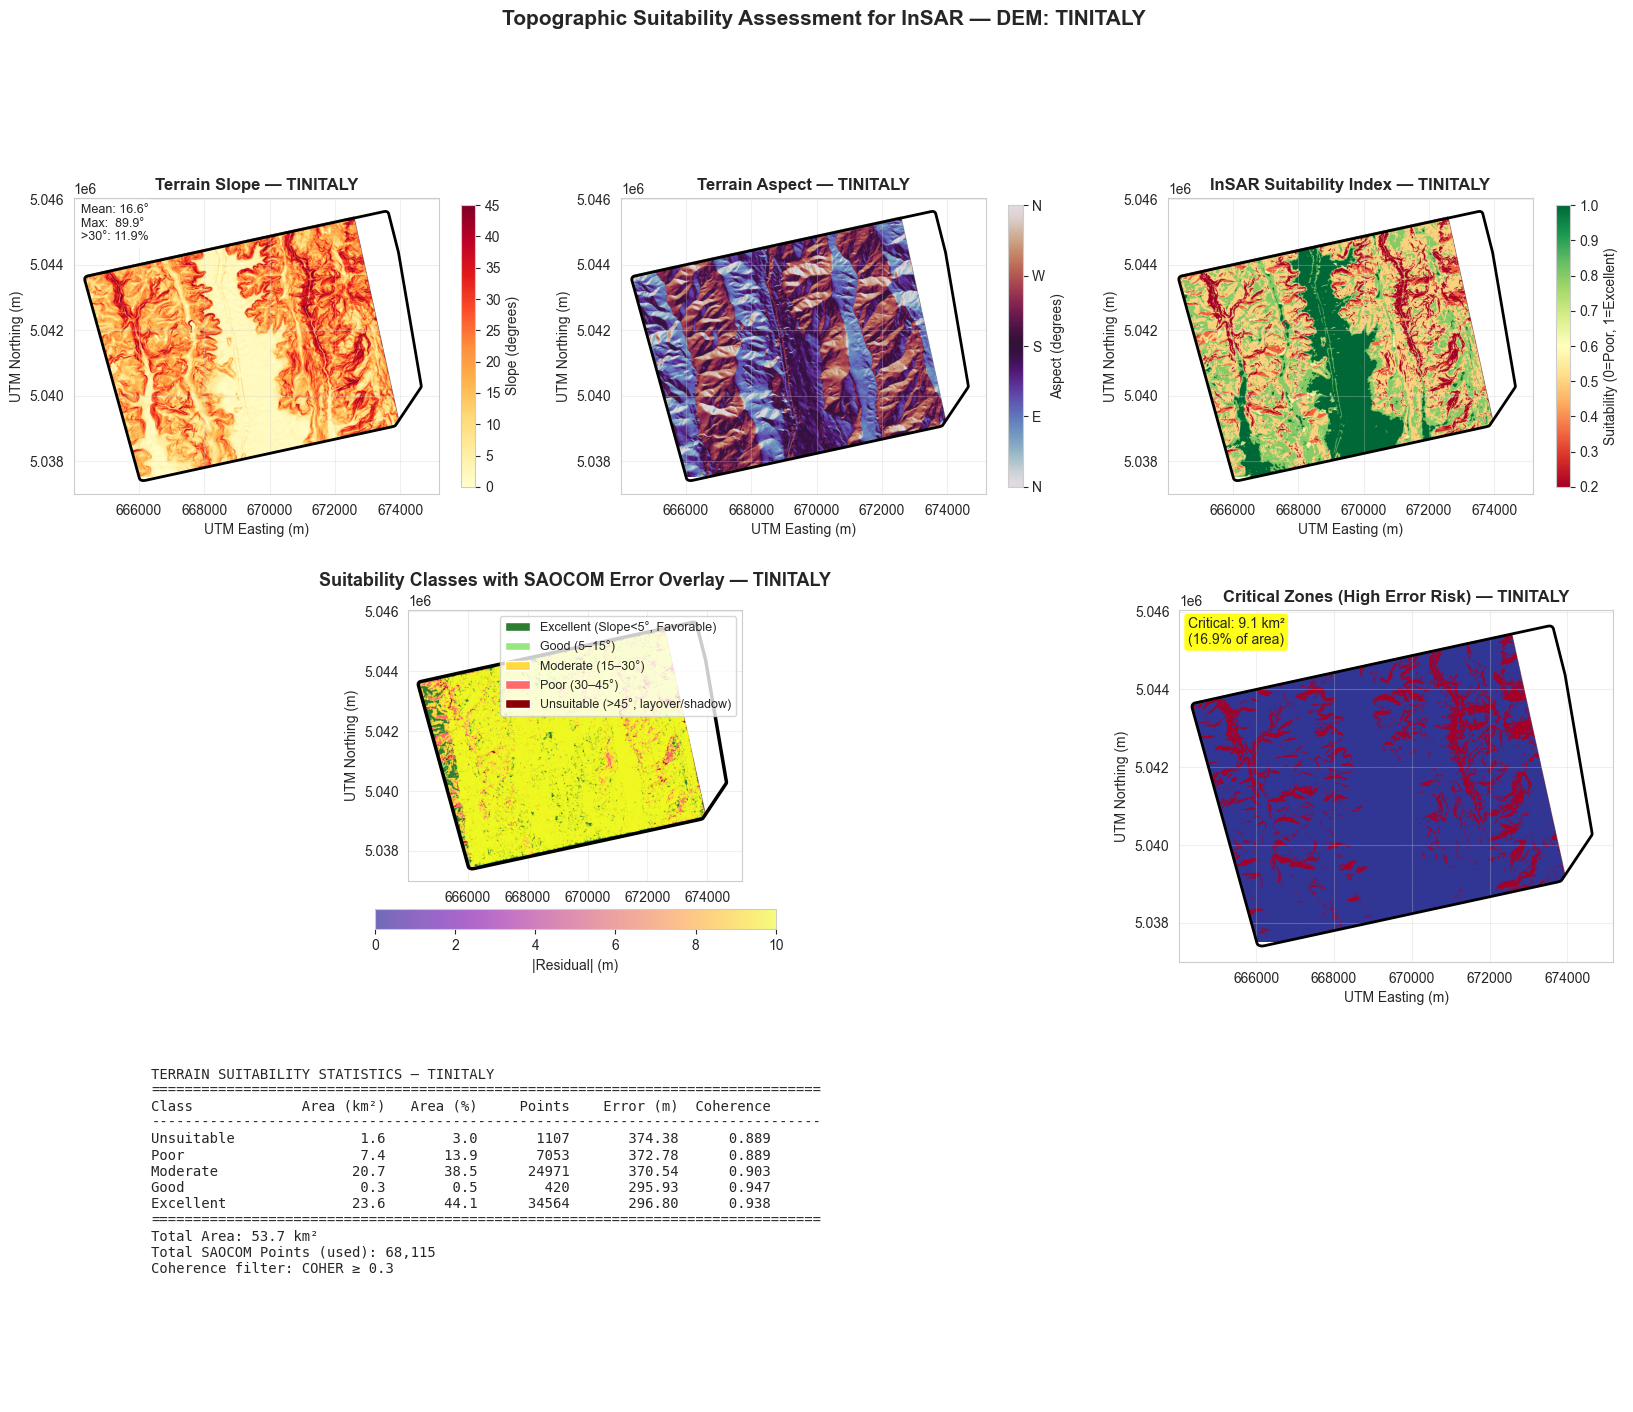

Saving suitability rasters for DEM: TINITALY...
  ✓ results\insar_terrain_suitability_tinitaly.tif
  ✓ results\insar_suitability_index_tinitaly.tif

Processing DEM: Copernicus


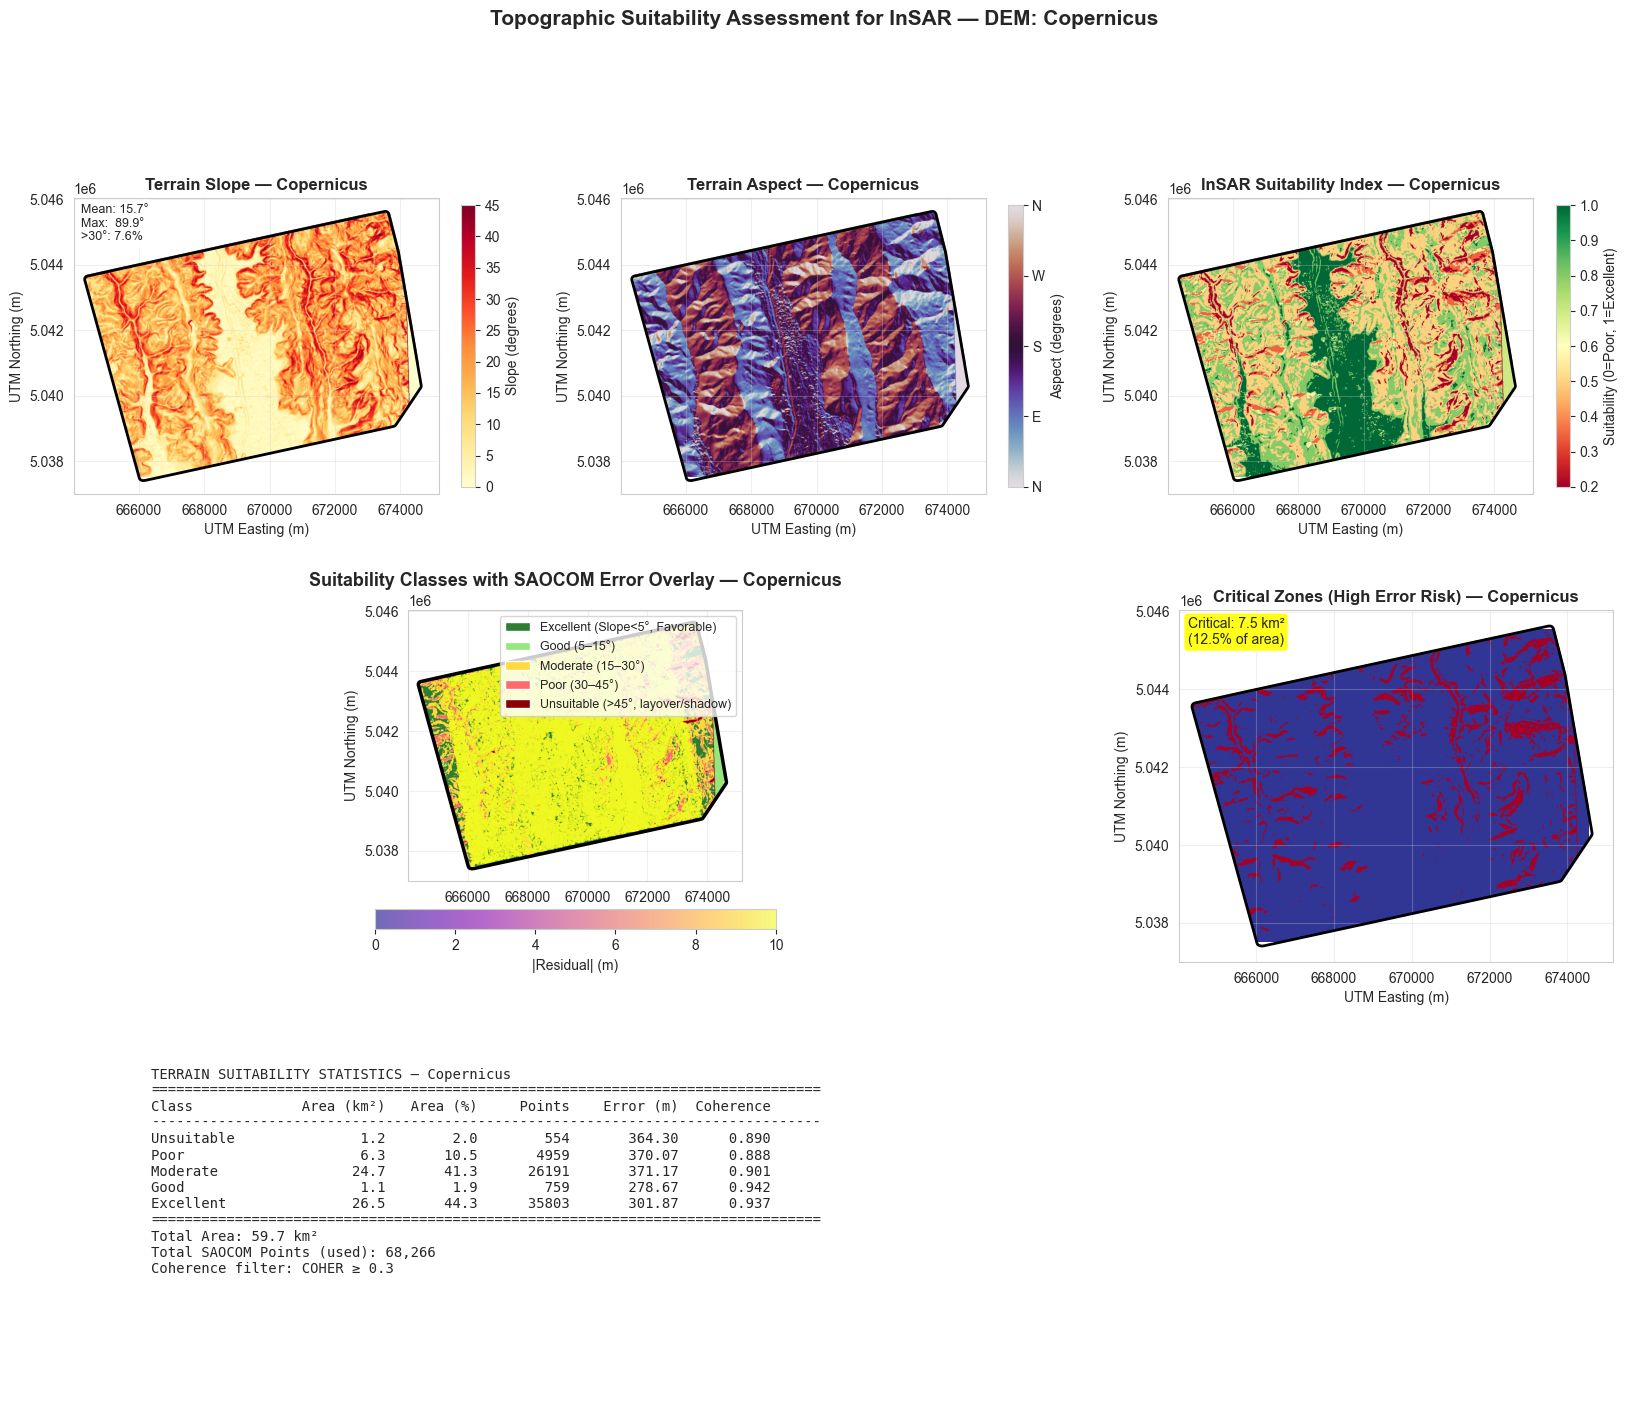

Saving suitability rasters for DEM: Copernicus...
  ✓ results\insar_terrain_suitability_copernicus.tif
  ✓ results\insar_suitability_index_copernicus.tif

Done. DEM-specific figures/rasters created and SAOCOM residuals handled per DEM.

ANALYSIS COMPLETE
All results saved to: results
Total figures generated: 10+
Total rasters generated: 15


In [27]:
# Cell 25: Terrain Suitability Visualization
# =============================================================================
# Configuration for each DEM
dem_configs = [
    {
        'name': 'TINITALY',
        'dem': tinitaly_10m,
        'slope': tinitaly_slope,
        'aspect': tinitaly_aspect,
        'elev': tinitaly_10m,
        'suitability': tin_suitability,
        'class': tin_class,
        'saocom_height_col': 'HEIGHT_ABSOLUTE_TIN',
        'ref_height_col': 'tinitaly_height',
        'residual_col': 'diff_tinitaly'
    },
    {
        'name': 'Copernicus',
        'dem': copernicus_10m,
        'slope': copernicus_slope,
        'aspect': copernicus_aspect,
        'elev': copernicus_10m,
        'suitability': cop_suitability,
        'class': cop_class,
        'saocom_height_col': 'HEIGHT_ABSOLUTE_COP',
        'ref_height_col': 'copernicus_height',
        'residual_col': 'diff_copernicus'
    }
]

COHER_MIN = COHERENCE_THRESHOLD
extent = [xmin_grid, xmax_grid, ymin_grid, ymax_grid]

def saocom_prepare_for_dem(cfg, gdf, grid_valid, gh, gw, trans):
    """Filter and prepare SAOCOM data for a specific DEM."""
    mask = (gdf[cfg['saocom_height_col']].notna() & 
            gdf[cfg['ref_height_col']].notna() &
            gdf[cfg['residual_col']].notna())
    
    if COHER_MIN > 0:
        mask = mask & (gdf['COHER'] >= COHER_MIN)
    
    result = gdf[mask].copy()
    result['err'] = result[cfg['residual_col']]
    
    # Get grid coordinates
    xs, ys = result.geometry.x.values, result.geometry.y.values
    r, c = rowcol(trans, xs, ys)
    valid_pos = (r >= 0) & (r < gh) & (c >= 0) & (c < gw)
    
    result = result[valid_pos].reset_index(drop=True)
    r, c = r[valid_pos], c[valid_pos]
    result['row'] = r
    result['col'] = c
    
    return result

# Generate visualization for each DEM
for cfg in dem_configs:
    dem_name = cfg['name']
    slope, aspect, elev = cfg['slope'], cfg['aspect'], cfg['elev']
    
    print(f"\nProcessing DEM: {dem_name}")
    
    grid_valid = np.isfinite(slope) & np.isfinite(aspect) & np.isfinite(elev)
    suitability = cfg['suitability']
    sclass = cfg['class']
    
    saocom_dem = saocom_prepare_for_dem(
        cfg, saocom_gdf, grid_valid, grid_height, grid_width, target_transform
    )
    
    # Create figure
    fig = plt.figure(figsize=(20, 16), facecolor='white')
    gs = fig.add_gridspec(3, 3, hspace=0.25, wspace=0.2)
    
    # 1) Slope
    ax1 = fig.add_subplot(gs[0, 0])
    im1 = ax1.imshow(np.where(grid_valid, slope, np.nan), extent=extent, 
                    cmap='YlOrRd', vmin=0, vmax=45)
    hull_gdf.boundary.plot(ax=ax1, color='black', linewidth=2)
    ax1.set_title(f'Terrain Slope — {dem_name}', fontsize=12, fontweight='bold')
    ax1.set_xlabel('UTM Easting (m)')
    ax1.set_ylabel('UTM Northing (m)')
    plt.colorbar(im1, ax=ax1, label='Slope (degrees)', shrink=0.8)
    ax1.grid(True, alpha=0.3)
    
    slope_disp = np.where(grid_valid, slope, np.nan)
    ax1.text(0.02, 0.98,
            f"Mean: {np.nanmean(slope_disp):.1f}°\n"
            f"Max:  {np.nanmax(slope_disp):.1f}°\n"
            f">30°: {(np.nansum(slope_disp>30)/grid_valid.sum()*100):.1f}%",
            transform=ax1.transAxes, fontsize=9, va='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    # 2) Aspect
    ax2 = fig.add_subplot(gs[0, 1])
    im2 = ax2.imshow(np.where(grid_valid, aspect, np.nan), extent=extent, 
                    cmap=plt.cm.twilight, vmin=0, vmax=360)
    hull_gdf.boundary.plot(ax=ax2, color='black', linewidth=2)
    ax2.set_title(f'Terrain Aspect — {dem_name}', fontsize=12, fontweight='bold')
    ax2.set_xlabel('UTM Easting (m)')
    ax2.set_ylabel('UTM Northing (m)')
    cbar2 = plt.colorbar(im2, ax=ax2, label='Aspect (degrees)', shrink=0.8)
    cbar2.set_ticks([0, 90, 180, 270, 360])
    cbar2.set_ticklabels(['N', 'E', 'S', 'W', 'N'])
    ax2.grid(True, alpha=0.3)
    
    # 3) Suitability Index
    ax3 = fig.add_subplot(gs[0, 2])
    im3 = ax3.imshow(np.where(grid_valid, suitability, np.nan), extent=extent, 
                    cmap='RdYlGn', vmin=0.2, vmax=1.0)
    hull_gdf.boundary.plot(ax=ax3, color='black', linewidth=2)
    ax3.set_title(f'InSAR Suitability Index — {dem_name}', fontsize=12, fontweight='bold')
    ax3.set_xlabel('UTM Easting (m)')
    ax3.set_ylabel('UTM Northing (m)')
    plt.colorbar(im3, ax=ax3, label='Suitability (0=Poor, 1=Excellent)', shrink=0.8)
    ax3.grid(True, alpha=0.3)
    
    # 4) Suitability Class + SAOCOM overlay
    ax4 = fig.add_subplot(gs[1, :2])
    cmap_discrete = ListedColormap(['#8B0000', '#FF6B6B', '#FFD93D', '#95E77E', '#2E7D32'])
    norm = BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], cmap_discrete.N)
    im4 = ax4.imshow(np.where(grid_valid, sclass, np.nan), extent=extent, 
                    cmap=cmap_discrete, norm=norm)
    hull_gdf.boundary.plot(ax=ax4, color='black', linewidth=2.5)
    
    scatter_vals = np.abs(saocom_dem['err'].to_numpy())
    scatter = ax4.scatter(saocom_dem['x_utm'], saocom_dem['y_utm'],
                         c=scatter_vals, s=2, cmap='plasma',
                         vmin=0, vmax=10, alpha=0.6, edgecolors='none')
    ax4.set_title(f'Suitability Classes with SAOCOM Error Overlay — {dem_name}', 
                 fontsize=13, fontweight='bold')
    ax4.set_xlabel('UTM Easting (m)')
    ax4.set_ylabel('UTM Northing (m)')
    ax4.grid(True, alpha=0.3)
    ax4.legend(handles=[
        Patch(facecolor='#2E7D32', label='Excellent (Slope<5°, Favorable)'),
        Patch(facecolor='#95E77E', label='Good (5–15°)'),
        Patch(facecolor='#FFD93D', label='Moderate (15–30°)'),
        Patch(facecolor='#FF6B6B', label='Poor (30–45°)'),
        Patch(facecolor='#8B0000', label='Unsuitable (>45°, layover/shadow)')],
        loc='upper right', fontsize=9)
    plt.colorbar(scatter, ax=ax4, label='|Residual| (m)', shrink=0.4,
                orientation='horizontal', pad=0.08)
    
    # 5) Critical Zones
    ax5 = fig.add_subplot(gs[1, 2])
    critical = grid_valid & ((slope > 30) | ((slope > 15) & ((aspect < 45) | (aspect > 315))))
    im5 = ax5.imshow(np.where(grid_valid, critical.astype(float), np.nan), 
                    extent=extent, cmap='RdYlBu_r', vmin=0, vmax=1)
    hull_gdf.boundary.plot(ax=ax5, color='black', linewidth=2)
    ax5.set_title(f'Critical Zones (High Error Risk) — {dem_name}', 
                 fontsize=12, fontweight='bold')
    ax5.set_xlabel('UTM Easting (m)')
    ax5.set_ylabel('UTM Northing (m)')
    ax5.grid(True, alpha=0.3)
    
    total_area = grid_valid.sum() * pixel_area_km2
    critical_area = np.nansum(critical) * pixel_area_km2
    ax5.text(0.02, 0.98, f"Critical: {critical_area:.1f} km²\n"
                         f"({critical_area/total_area*100:.1f}% of area)",
            transform=ax5.transAxes, fontsize=10, va='top',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.9))
    
    # 6) Statistics Table
    ax6 = fig.add_subplot(gs[2, :])
    ax6.axis('off')
    
    r_v = saocom_dem['row'].to_numpy(dtype=int)
    c_v = saocom_dem['col'].to_numpy(dtype=int)
    saocom_classes = sclass[r_v, c_v]
    
    stats = []
    class_names = ['Unsuitable', 'Poor', 'Moderate', 'Good', 'Excellent']
    for i in range(5):
        cmask = (sclass == i) & grid_valid
        area_km2 = cmask.sum() * pixel_area_km2
        area_pct = (cmask.sum() / grid_valid.sum() * 100.0) if grid_valid.any() else 0.0
        
        pts_mask = (saocom_classes == i)
        if np.any(pts_mask):
            pts = saocom_dem.loc[pts_mask]
            mean_error = np.nanmean(np.abs(pts['err']))
            mean_coh = np.nanmean(pts['COHER']) if 'COHER' in pts.columns else np.nan
            n_points = len(pts)
        else:
            mean_error = np.nan
            mean_coh = np.nan
            n_points = 0
        
        stats.append([class_names[i], area_km2, area_pct, n_points, mean_error, mean_coh])
    
    df_stats = pd.DataFrame(stats, columns=['Suitability', 'Area (km²)', 'Area (%)', 
                                            'SAOCOM Points', 'Mean Error (m)', 'Mean Coherence'])
    table_text = f"TERRAIN SUITABILITY STATISTICS — {dem_name}\n" + "="*80 + "\n"
    table_text += f"{'Class':<15} {'Area (km²)':>12} {'Area (%)':>10} {'Points':>10} "
    table_text += f"{'Error (m)':>12} {'Coherence':>10}\n"
    table_text += "-"*80 + "\n"
    for _, row in df_stats.iterrows():
        table_text += f"{row['Suitability']:<15} {row['Area (km²)']:>12.1f} "
        table_text += f"{row['Area (%)']:>10.1f} {row['SAOCOM Points']:>10.0f} "
        if not np.isnan(row['Mean Error (m)']):
            table_text += f"{row['Mean Error (m)']:>12.2f} {row['Mean Coherence']:>10.3f}\n"
        else:
            table_text += f"{'N/A':>12} {'N/A':>10}\n"
    table_text += "="*80 + f"\nTotal Area: {total_area:.1f} km²\n"
    table_text += f"Total SAOCOM Points (used): {len(saocom_dem):,}\n"
    if COHER_MIN > 0:
        table_text += f"Coherence filter: COHER ≥ {COHER_MIN}\n"
    
    ax6.text(0.05, 0.95, table_text, transform=ax6.transAxes,
            fontsize=10, va='top', fontfamily='monospace')
    
    plt.suptitle(f'Topographic Suitability Assessment for InSAR — DEM: {dem_name}',
                fontsize=15, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / f'terrain_suitability_{dem_name.lower()}.png', 
               dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save rasters
    print(f"Saving suitability rasters for DEM: {dem_name}...")
    profile_raster = dict(driver='GTiff', height=grid_height, width=grid_width, count=1,
                         crs=TARGET_CRS, transform=target_transform)
    
    out_class = RESULTS_DIR / f"insar_terrain_suitability_{dem_name.lower()}.tif"
    prof_cls = profile_raster.copy()
    prof_cls.update(dtype='uint8', nodata=255)
    with rasterio.open(out_class, 'w', **prof_cls) as dst:
        dst.write(np.where(grid_valid, sclass, 255).astype(np.uint8), 1)
        dst.set_band_description(1, f'InSAR Terrain Suitability (0–4) — {dem_name}')
    print(f"  ✓ {out_class}")
    
    out_index = RESULTS_DIR / f"insar_suitability_index_{dem_name.lower()}.tif"
    prof_idx = profile_raster.copy()
    prof_idx.update(dtype='float32', nodata=-9999)
    with rasterio.open(out_index, 'w', **prof_idx) as dst:
        dst.write(np.where(grid_valid, suitability, -9999).astype(np.float32), 1)
        dst.set_band_description(1, f'InSAR Suitability Index (0–1) — {dem_name}')
    print(f"  ✓ {out_index}")

print("\nDone. DEM-specific figures/rasters created and SAOCOM residuals handled per DEM.")

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)
print(f"All results saved to: {RESULTS_DIR}")
print(f"Total figures generated: 10+")
print(f"Total rasters generated: {len(list(RESULTS_DIR.glob('*.tif')))}")
print("="*70)
